In [70]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [71]:
# Define the Maze class
class Maze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height = maze.shape[0]  # Get the height of the maze (number of rows)
        self.maze_width = maze.shape[1]   # Get the width of the maze (number of columns)
        self.start_position = start_position  # Set the start position in the maze as a tuple (x, y)
        self.goal_position = goal_position    # Set the goal position in the maze as a tuple (x, y)

    def show_maze(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', 
                ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', 
                ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

# Define possible actions: Up, Down, Left, Right
actions = [(-1, 0),  # Up: Moving one step up, reducing the row index by 1
           (1, 0),   # Down: Moving one step down, increasing the row index by 1
           (0, -1),  # Left: Moving one step to the left, reducing the column index by 1
           (0, 1)]   # Right: Moving one step to the right, increasing the column index by 1

# Define reward system
goal_reward = 100    # Reward for reaching the goal
wall_penalty = -10   # Penalty for hitting a wall
step_penalty = -1    # Small penalty for each step to encourage finding shortest path

In [72]:
# Part 1: Actor-Critic Network Architecture
class ActorCriticNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(ActorCriticNetwork, self).__init__()
        # Common layers for both actor and critic
        self.common = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        # Actor head (policy network)
        self.actor = nn.Sequential(
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=-1)
        )
        
        # Critic head (value network)
        self.critic = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        common_features = self.common(state)
        action_probs = self.actor(common_features)
        state_value = self.critic(common_features)
        return action_probs, state_value

In [73]:
# Part 2: Intrinsic Curiosity Module
class ICMNetwork(nn.Module):
    def __init__(self, state_size, hidden_size, num_actions):
        super(ICMNetwork, self).__init__()
        
        # Forward model
        self.forward_model = nn.Sequential(
            nn.Linear(state_size + num_actions, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, state_size)
        )
        
        # Inverse model
        self.inverse_model = nn.Sequential(
            nn.Linear(state_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_actions)
        )
        
    def forward(self, current_state, next_state, action):
        # Add batch dimension if needed
        if current_state.dim() == 1:
            current_state = current_state.unsqueeze(0)
        if next_state.dim() == 1:
            next_state = next_state.unsqueeze(0)
        if action.dim() == 0:
            action = action.unsqueeze(0)
            
        # Inverse model: predict action from states
        state_pair = torch.cat([current_state, next_state], dim=-1)
        predicted_action = self.inverse_model(state_pair)
        
        # Forward model: predict next state
        one_hot_action = F.one_hot(action, 4).float()
        state_action = torch.cat([current_state, one_hot_action], dim=-1)
        predicted_next_state = self.forward_model(state_action)
        
        return predicted_next_state.squeeze(0), predicted_action.squeeze(0)

In [74]:
class EnhancedMazeAgent:
    def __init__(self, maze, learning_rate=0.001, gamma=0.99, hidden_size=64):
        self.maze = maze
        self.state_size = 2  # x, y coordinates
        self.num_actions = 4  # up, down, left, right
        
        # Initialize networks
        self.actor_critic = ActorCriticNetwork(self.state_size, hidden_size, self.num_actions)
        self.icm = ICMNetwork(self.state_size, hidden_size, self.num_actions)
        
        # Initialize optimizers
        self.ac_optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate)
        self.icm_optimizer = optim.Adam(self.icm.parameters(), lr=learning_rate)
        
        # Hyperparameters
        self.gamma = gamma
        self.curiosity_weight = 0.01
        
    def get_state_tensor(self, state):
        return torch.FloatTensor([state[0], state[1]])
    
    def get_action(self, state):
        state_tensor = self.get_state_tensor(state)
        action_probs, _ = self.actor_critic(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
        return action
    
    def compute_curiosity_reward(self, current_state, next_state, action):
        current_tensor = self.get_state_tensor(current_state)
        next_tensor = self.get_state_tensor(next_state)
        action_tensor = torch.tensor(action, dtype=torch.long)
        
        pred_next_state, _ = self.icm(current_tensor, next_tensor, action_tensor)
        curiosity_reward = F.mse_loss(pred_next_state, next_tensor).item()
        return curiosity_reward
    
    def update(self, state, action, reward, next_state, done):
        # Convert to tensors
       state_tensor = self.get_state_tensor(state)
       next_state_tensor = self.get_state_tensor(next_state)
       action_tensor = torch.tensor(action, dtype=torch.long).unsqueeze(0)  # Add batch dimension
       reward_tensor = torch.tensor(reward, dtype=torch.float).unsqueeze(0)  # Add batch dimension

       # Get predictions
       action_probs, state_value = self.actor_critic(state_tensor)
       _, next_state_value = self.actor_critic(next_state_tensor)

       # Compute TD error
       td_target = reward_tensor + (1 - done) * self.gamma * next_state_value.detach()
       td_error = td_target - state_value

       # Compute losses
       actor_loss = -torch.log(action_probs[action]) * td_error.detach()
       critic_loss = td_error.pow(2)

      # ICM forward-inverse model loss
       pred_next_state, pred_action = self.icm(state_tensor, next_state_tensor, action_tensor)
       forward_loss = F.mse_loss(pred_next_state, next_state_tensor)

       # Ensure pred_action has the right shape for cross_entropy
       pred_action = pred_action.view(1, self.num_actions)  # Add batch dimension and ensure shape is (1, num_actions)
       inverse_loss = F.cross_entropy(pred_action, action_tensor)  # No need to squeeze, shapes should match
       icm_loss = forward_loss + inverse_loss

      # Update networks
       self.ac_optimizer.zero_grad()
       (actor_loss + critic_loss).backward()
       self.ac_optimizer.step()

       self.icm_optimizer.zero_grad()
       icm_loss.backward()
       self.icm_optimizer.step()

       return actor_loss.item(), critic_loss.item(), icm_loss.item()


In [75]:
# Part 4: Enhanced Training Function with Visualization
def train_enhanced_agent(agent, maze, num_episodes=100, render_training=True):
    episode_rewards = []
    episode_steps = []
    training_losses = []
    
    fig = plt.figure(figsize=(15, 5))
    
    # Main training loop
    for episode in range(num_episodes):
        current_state = maze.start_position
        episode_reward = 0
        episode_step = 0
        path = [current_state]
        episode_losses = []
        
        while True:
            # Get action
            action = agent.get_action(current_state)
            
            # Execute action
            next_state = (current_state[0] + actions[action][0], 
                         current_state[1] + actions[action][1])
            
            # Check boundaries and walls
            if (next_state[0] < 0 or next_state[0] >= maze.maze_height or 
                next_state[1] < 0 or next_state[1] >= maze.maze_width or 
                maze.maze[next_state[1]][next_state[0]] == 1):
                reward = wall_penalty
                next_state = current_state
                done = False
            elif next_state == maze.goal_position:
                reward = goal_reward
                done = True
            else:
                reward = step_penalty
                done = False
            
            # Add curiosity reward
            curiosity_reward = agent.compute_curiosity_reward(current_state, next_state, action)
            total_reward = reward + agent.curiosity_weight * curiosity_reward
            
            # Update agent
            losses = agent.update(current_state, action, total_reward, next_state, done)
            episode_losses.append(losses)
            
            path.append(next_state)
            episode_reward += reward
            episode_step += 1
            
            if render_training and episode % 10 == 0:
                plt.clf()
                
                # Plot maze and path
                plt.subplot(131)
                plt.imshow(maze.maze, cmap='gray')
                plt.plot([p[0] for p in path], [p[1] for p in path], 'b-', linewidth=2)
                plt.plot(current_state[0], current_state[1], 'ro')
                plt.title(f'Episode {episode}')
                
                # Plot rewards
                plt.subplot(132)
                plt.plot(episode_rewards)
                plt.title('Episode Rewards')
                
                # Plot losses
                plt.subplot(133)
                if episode_losses:
                    actor_losses, critic_losses, icm_losses = zip(*episode_losses)
                    plt.plot(actor_losses, label='Actor')
                    plt.plot(critic_losses, label='Critic')
                    plt.plot(icm_losses, label='ICM')
                plt.title('Training Losses')
                plt.legend()
                
                plt.pause(0.1)
            
            if done:
                break
                
            current_state = next_state
        
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
        training_losses.append(np.mean(episode_losses, axis=0))
        
        if episode % 10 == 0:
            print(f'Episode {episode}: Reward = {episode_reward}, Steps = {episode_step}')
    
    plt.close()
    return episode_rewards, episode_steps, training_losses


In [76]:
# Part 5: Enhanced Testing Function with Visualization
def test_enhanced_agent(agent, maze, render_delay=0.5):
    current_state = maze.start_position
    path = [current_state]
    total_reward = 0
    steps = 0
    
    plt.figure(figsize=(6, 6))
    
    while True:
        # Clear previous plot
        plt.clf()
        
        # Plot maze
        plt.imshow(maze.maze, cmap='gray')
        
        # Plot full path
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        plt.plot(path_x, path_y, 'b-', linewidth=2)
        
        # Plot current position
        plt.plot(current_state[0], current_state[1], 'ro')
        
        # Plot start and goal
        plt.text(maze.start_position[0], maze.start_position[1], 'S', 
                ha='center', va='center', color='green', fontsize=15)
        plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
                ha='center', va='center', color='red', fontsize=15)
        
        plt.title(f'Step {steps}: Total Reward = {total_reward}')
        plt.pause(render_delay)
        
        # Get and execute action
        action = agent.get_action(current_state)
        next_state = (current_state[0] + actions[action][0], 
                     current_state[1] + actions[action][1])
        
        # Check boundaries and walls
        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or 
            next_state[1] < 0 or next_state[1] >= maze.maze_width or 
            maze.maze[next_state[1]][next_state[0]] == 1):
            reward = wall_penalty
            next_state = current_state
        elif next_state == maze.goal_position:
            reward = goal_reward
            path.append(next_state)
            total_reward += reward
            steps += 1
            break
        else:
            reward = step_penalty
        
        path.append(next_state)
        total_reward += reward
        steps += 1
        current_state = next_state
    
    # Final plot
    plt.clf()
    plt.imshow(maze.maze, cmap='gray')
    plt.plot(path_x, path_y, 'b-', linewidth=2)
    plt.plot([p[0] for p in path], [p[1] for p in path], 'ro-')
    plt.text(maze.start_position[0], maze.start_position[1], 'S', 
            ha='center', va='center', color='green', fontsize=15)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', 
            ha='center', va='center', color='red', fontsize=15)
    plt.title(f'Final Path: Steps = {steps}, Total Reward = {total_reward}')
    plt.show()
    
    return steps, total_reward


In [77]:
maze_layout = np.array([
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Update the start and goal positions
start_position = (0, 0)  # Top-left corner
goal_position = (9, 9)    # Bottom-right corner

maze = Maze(maze_layout, start_position, goal_position)
enhanced_agent = EnhancedMazeAgent(maze)


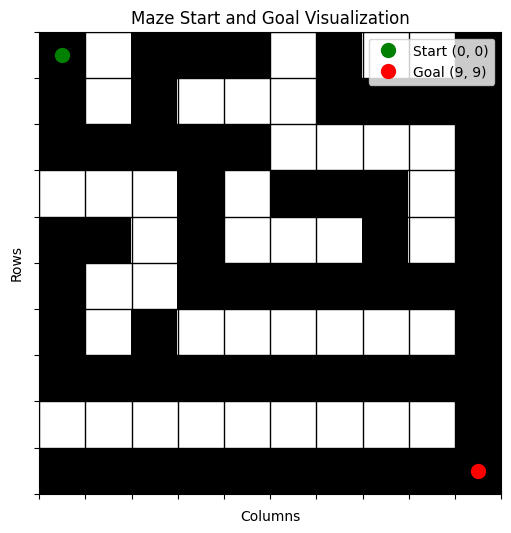

In [78]:
# Create the maze visualization
def visualize_start_goal(maze_layout, start, goal):
    plt.figure(figsize=(6, 6))
    
    # Show the maze
    plt.imshow(maze_layout, cmap='gray', origin='upper')

    # Highlight start position
    plt.plot(start[1], start[0], 'go', markersize=10, label='Start (0, 0)')

    # Highlight goal position
    plt.plot(goal[1], goal[0], 'ro', markersize=10, label='Goal (9, 9)')

    plt.title('Maze Start and Goal Visualization')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.xticks(np.arange(-0.5, maze_layout.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, maze_layout.shape[0], 1), [])
    plt.grid(color='black', linestyle='-', linewidth=1)
    plt.legend()
    plt.show()

# Call the visualization function
visualize_start_goal(maze_layout, start_position, goal_position)

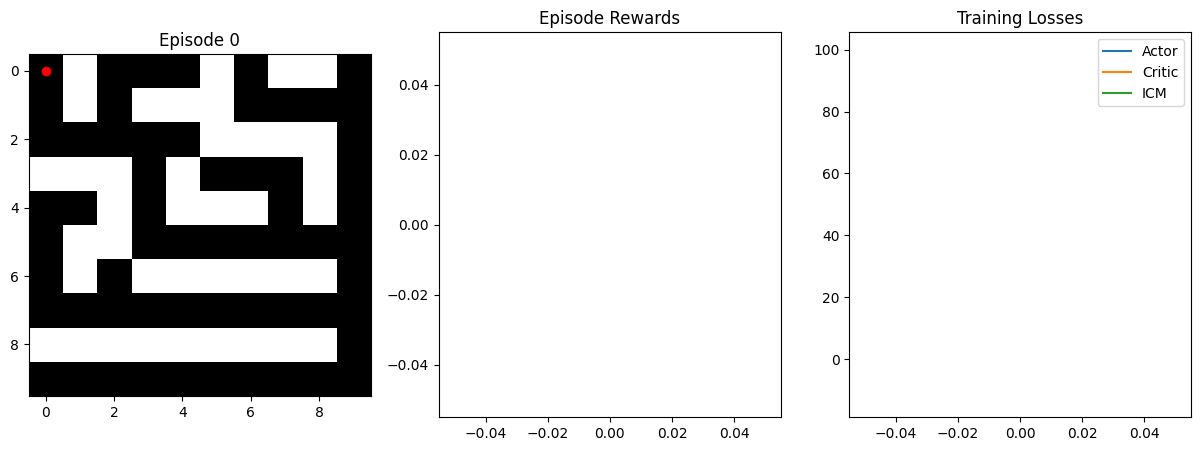

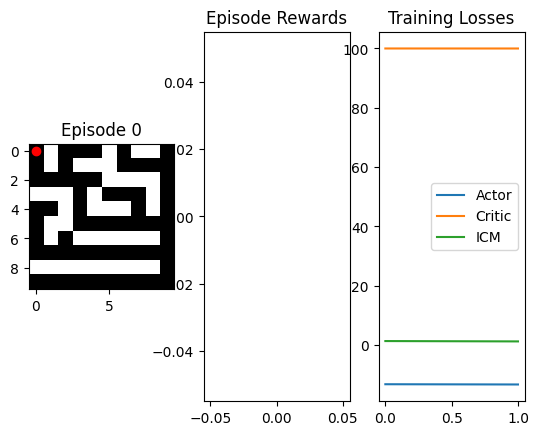

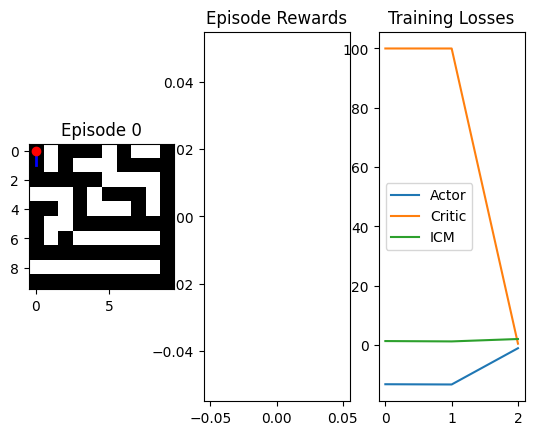

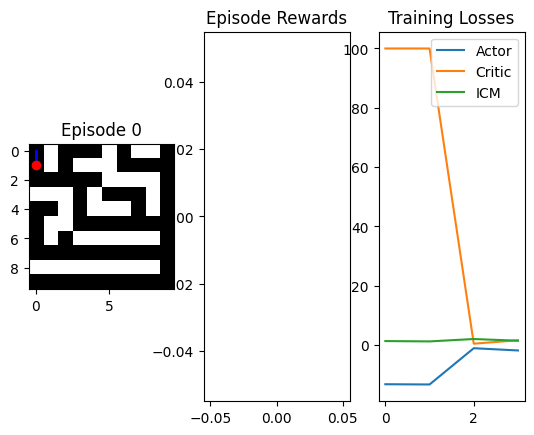

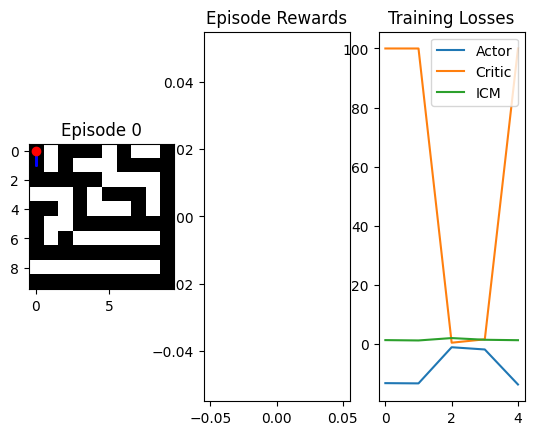

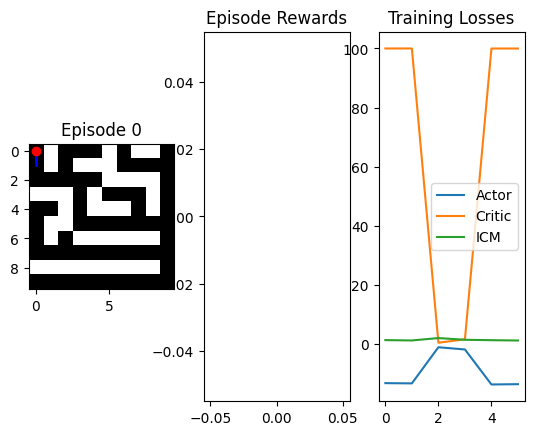

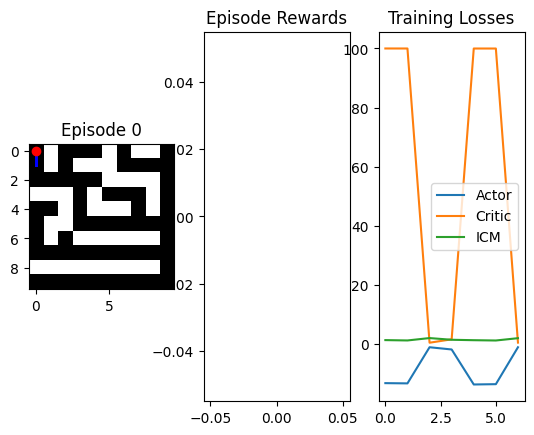

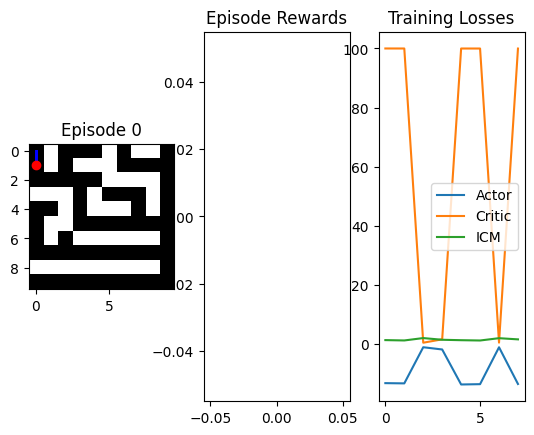

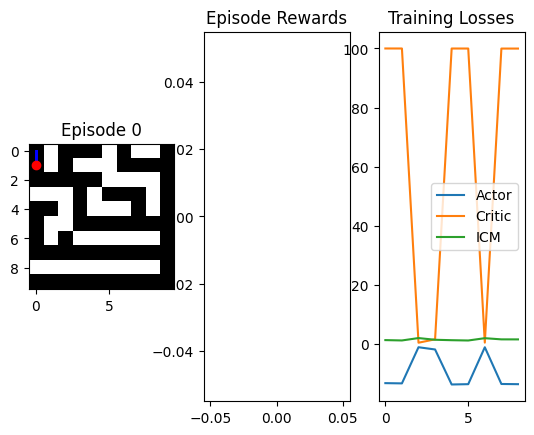

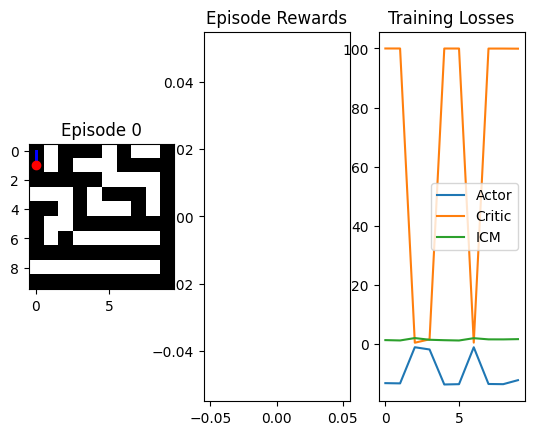

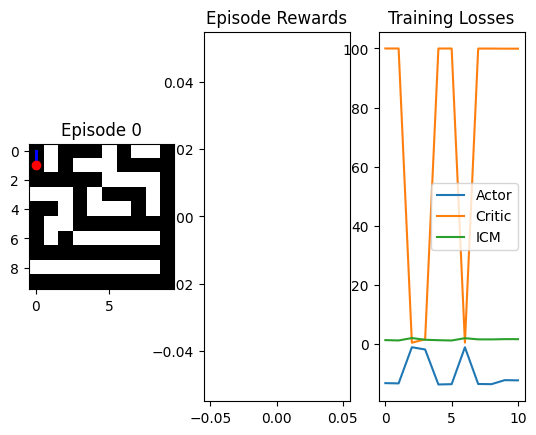

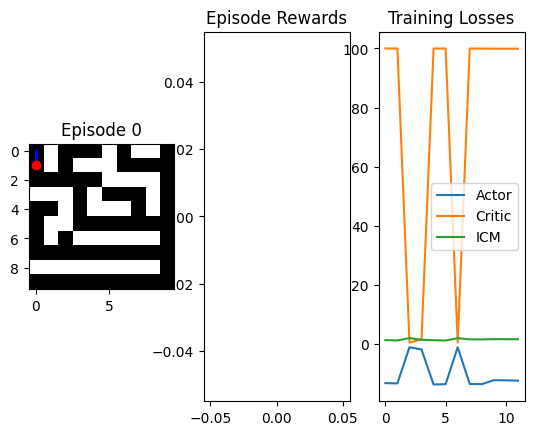

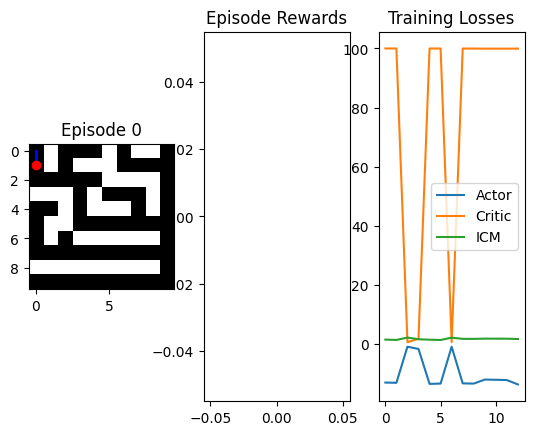

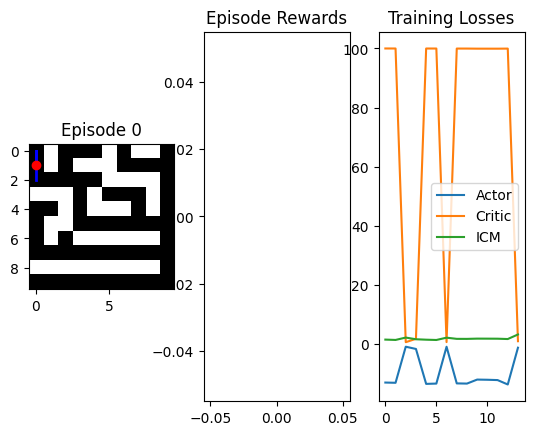

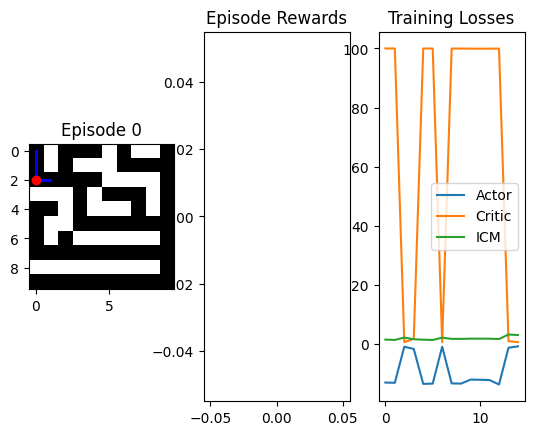

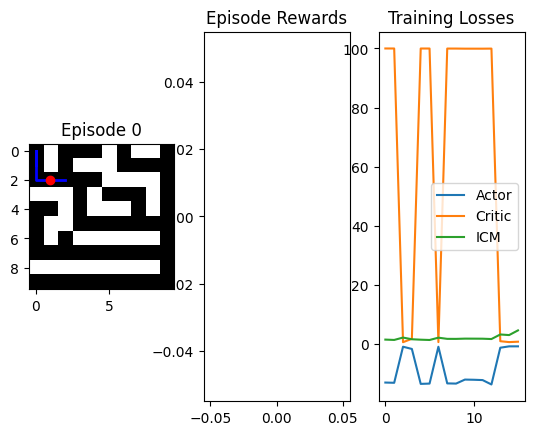

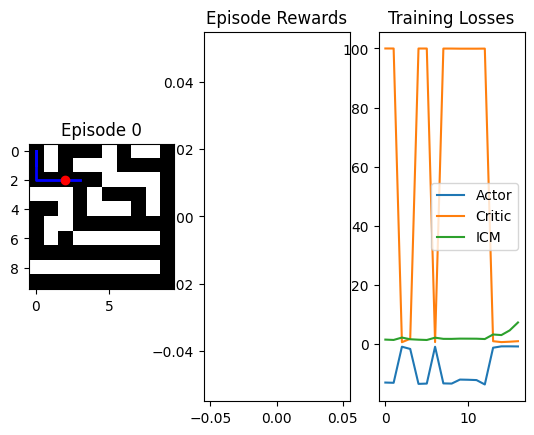

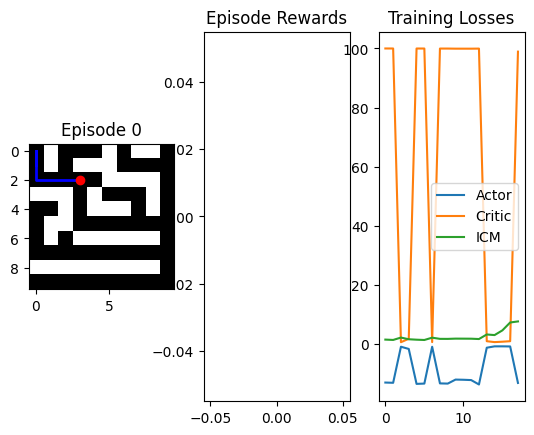

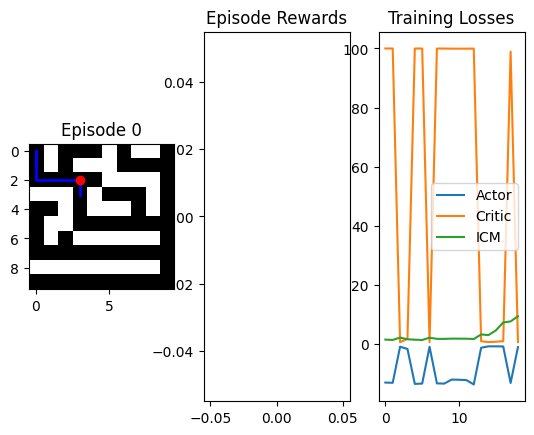

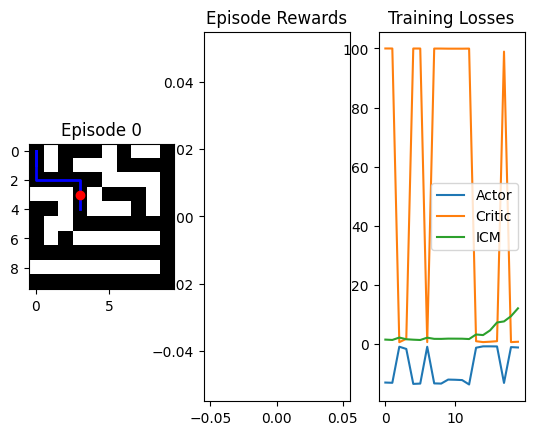

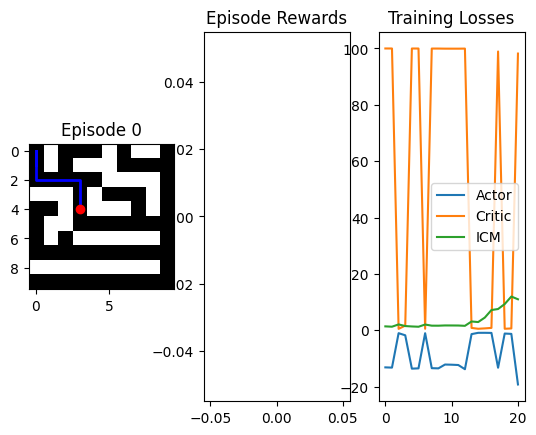

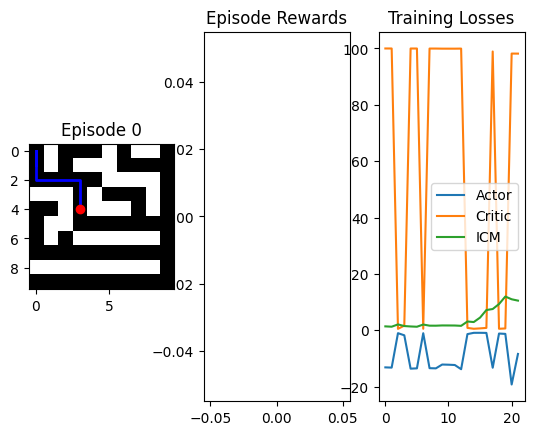

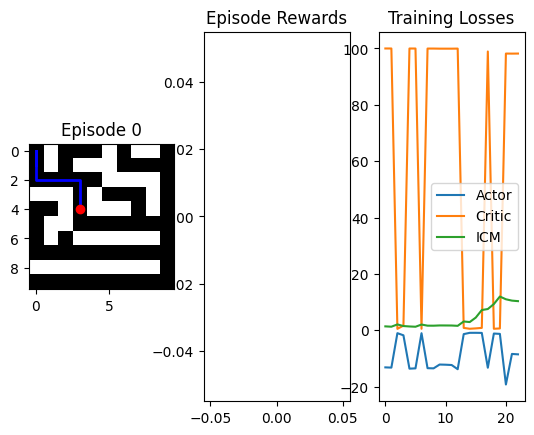

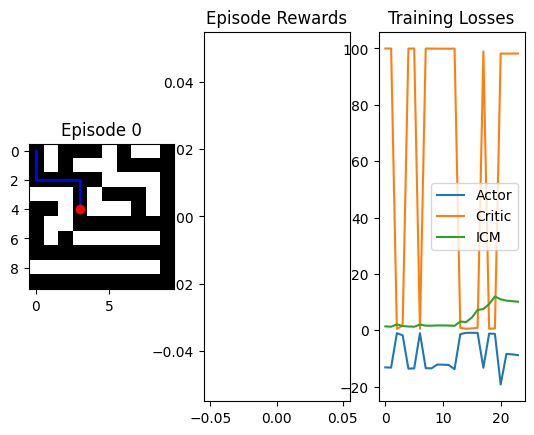

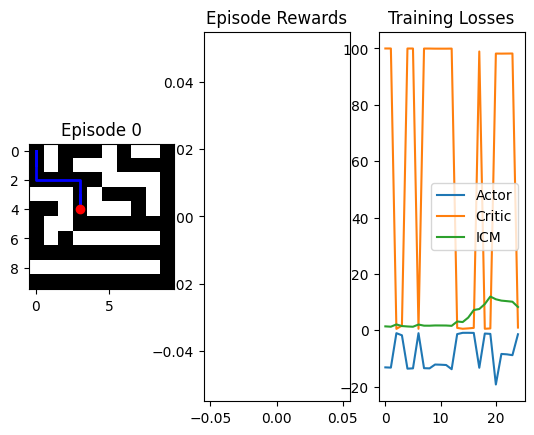

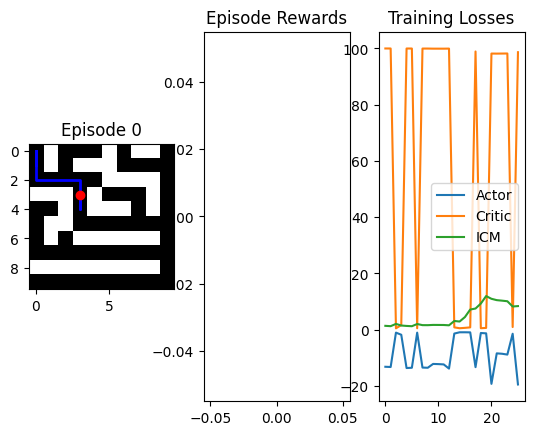

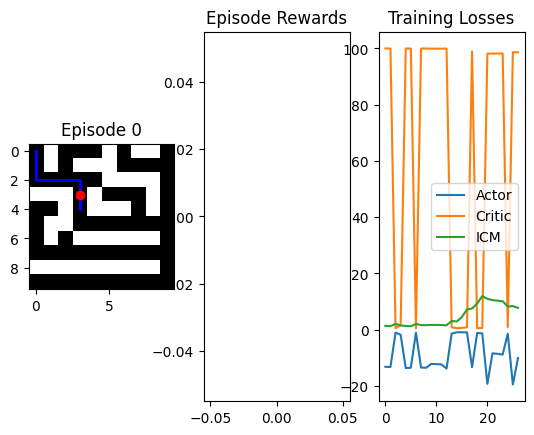

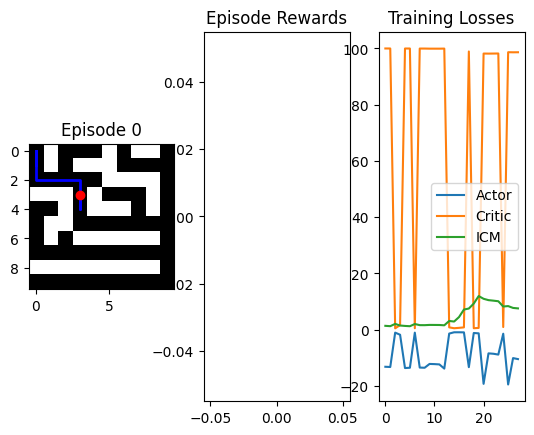

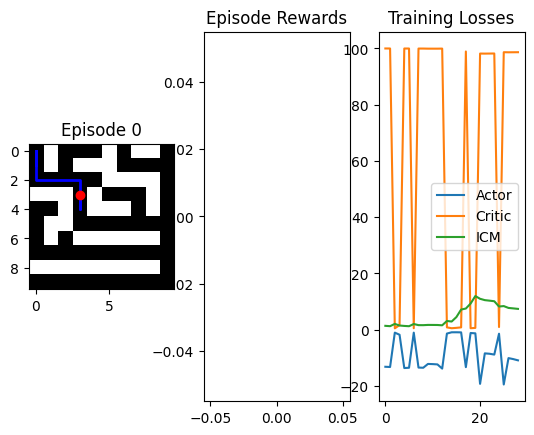

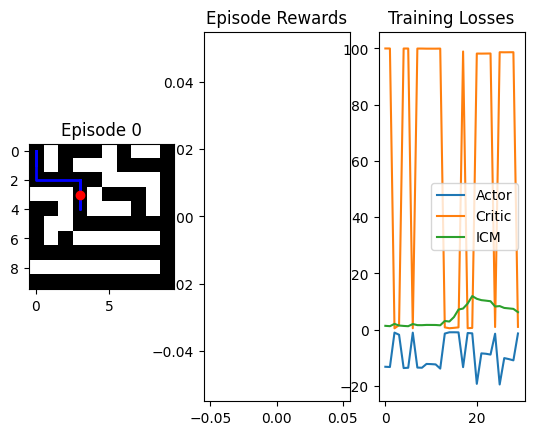

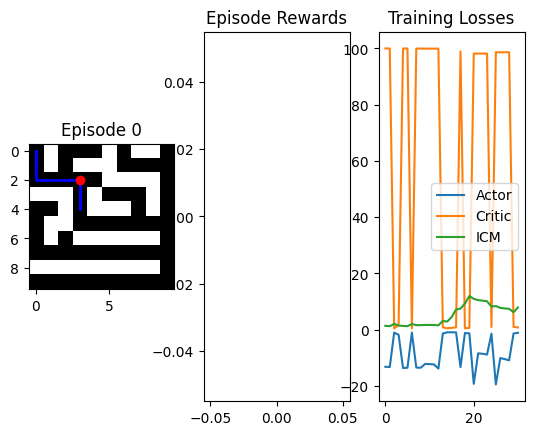

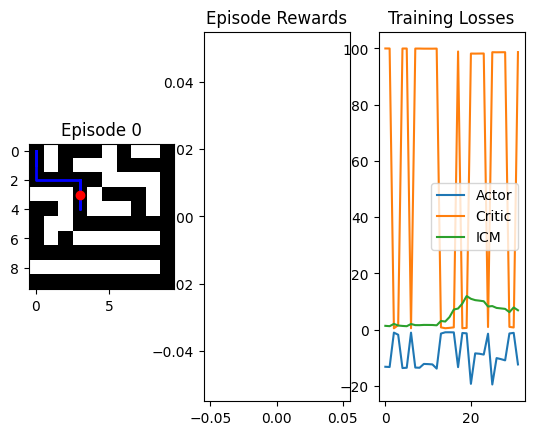

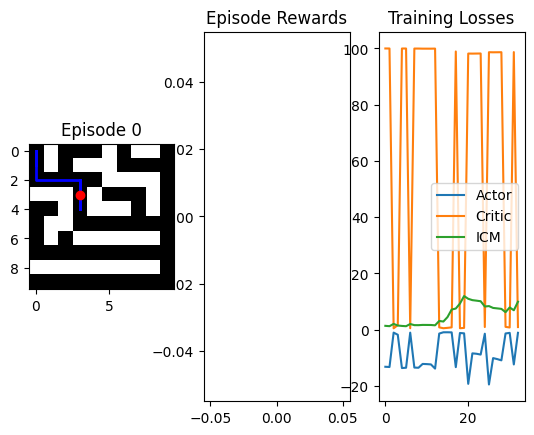

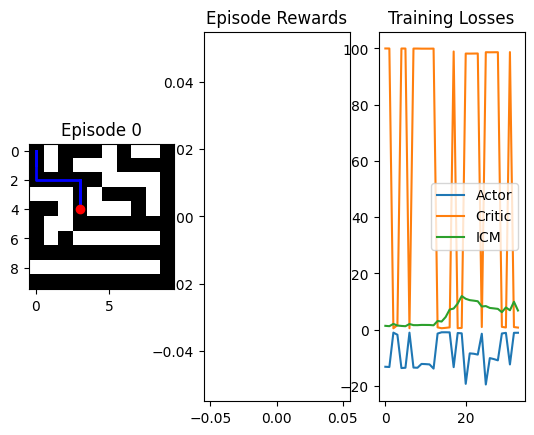

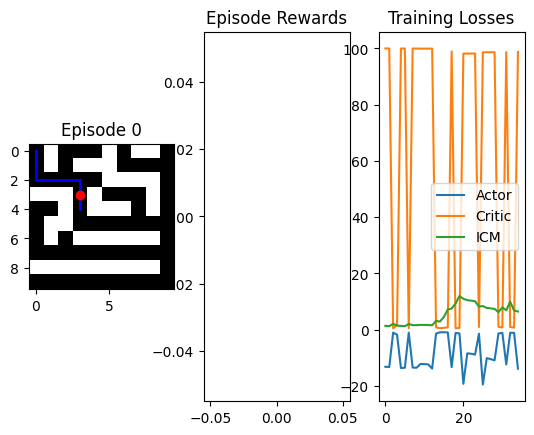

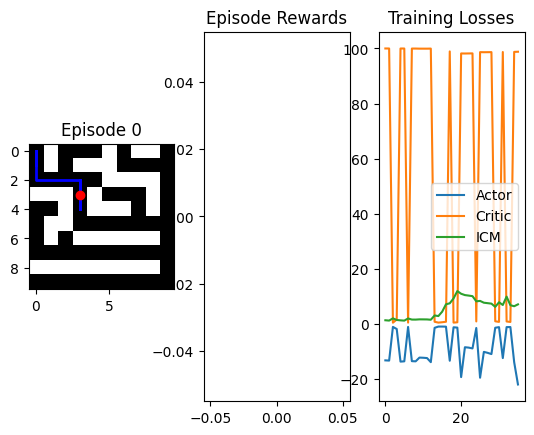

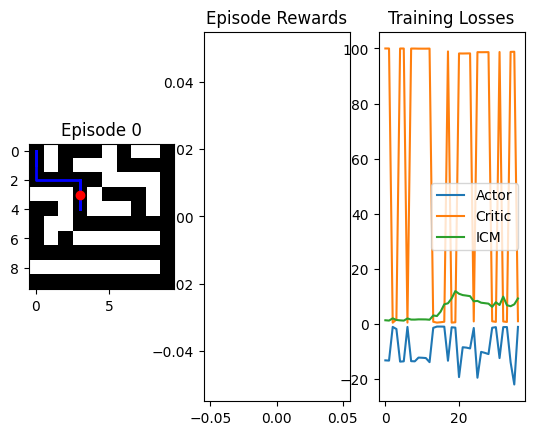

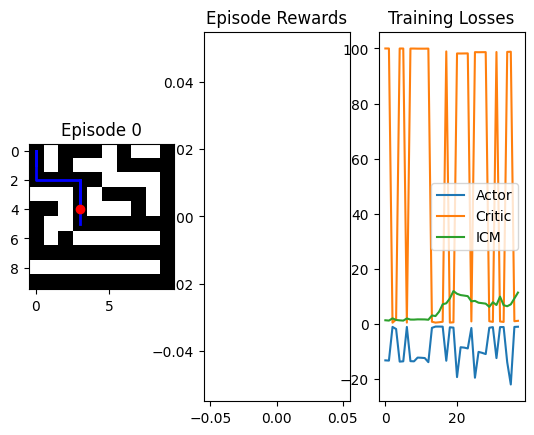

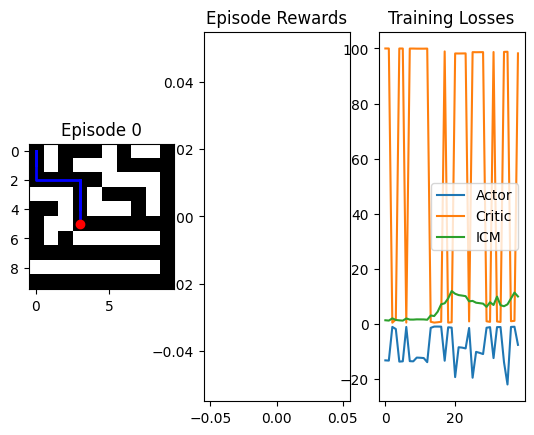

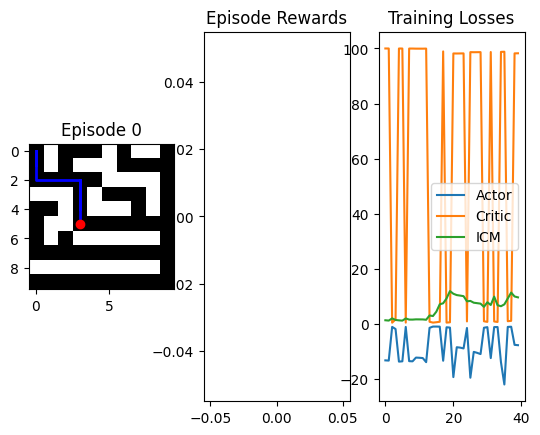

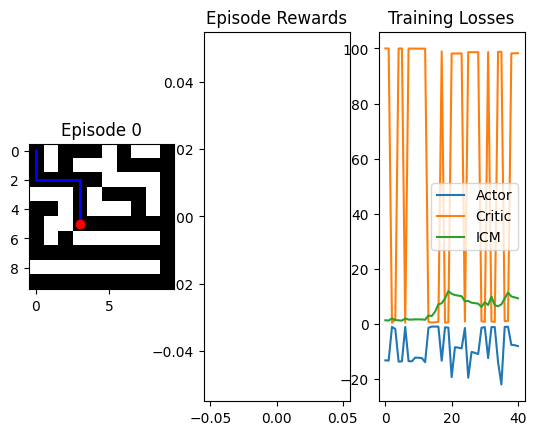

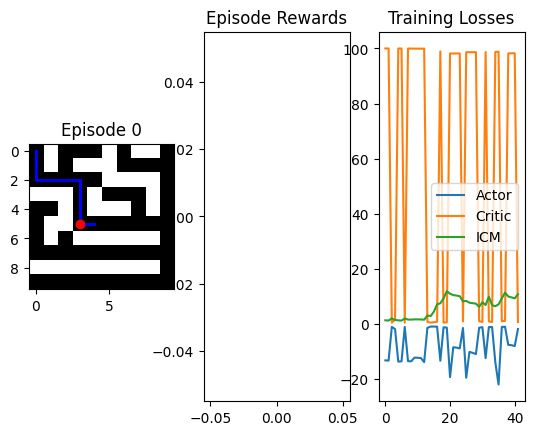

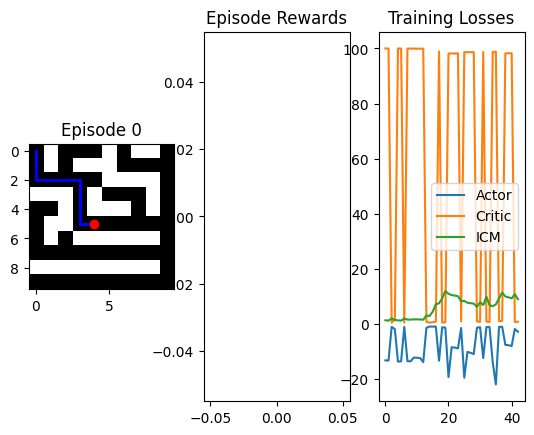

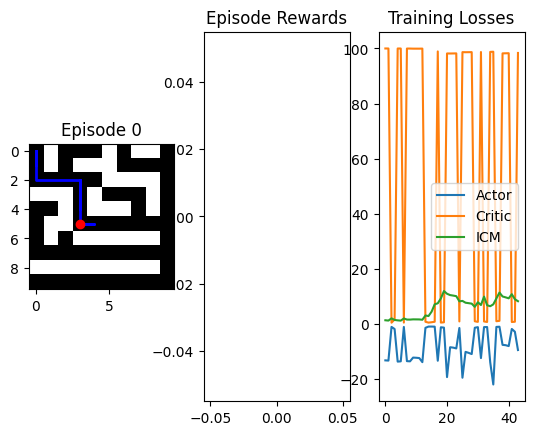

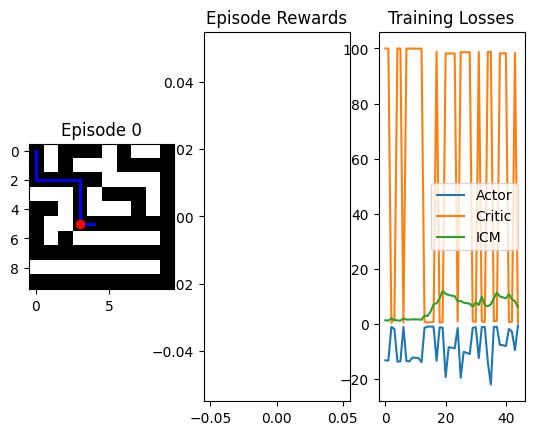

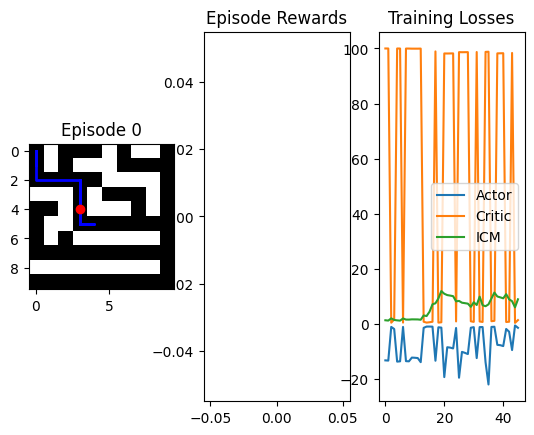

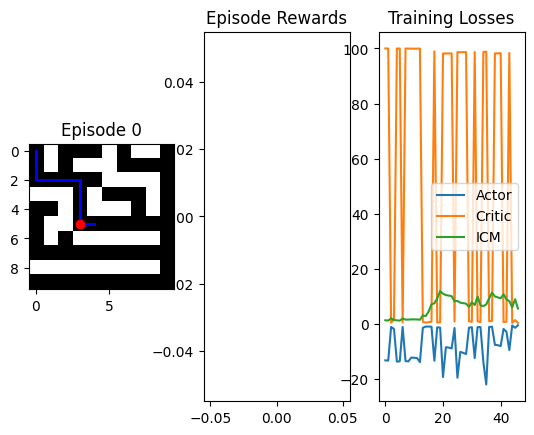

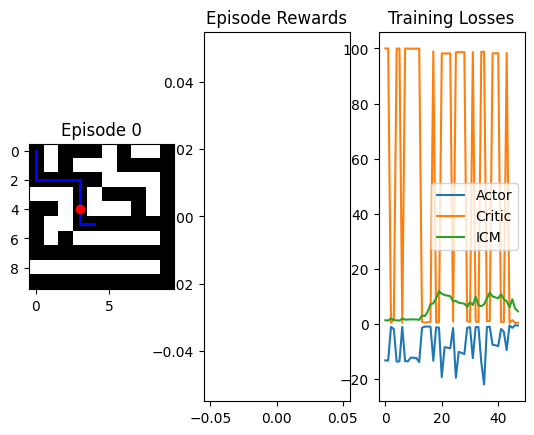

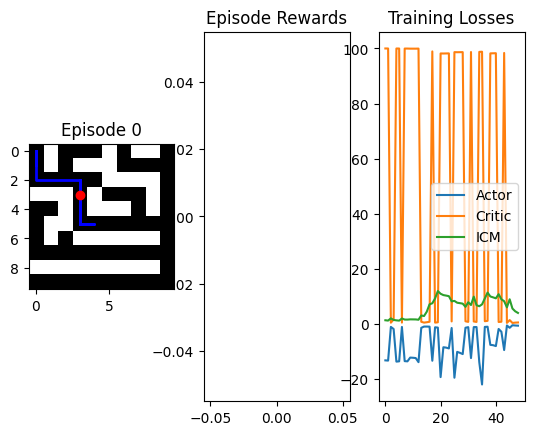

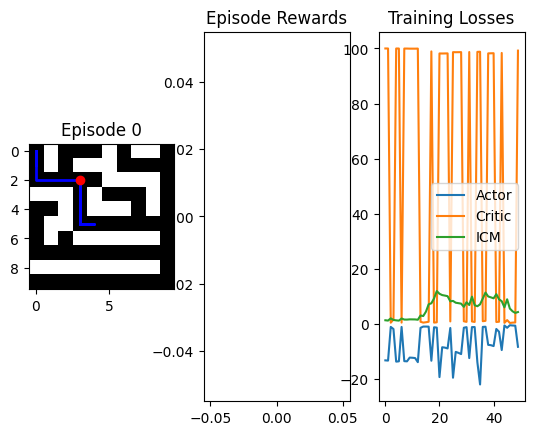

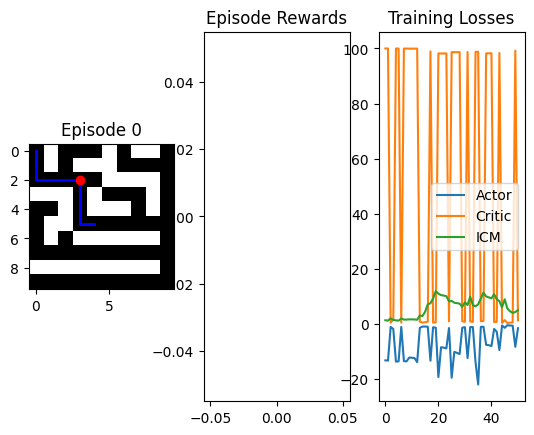

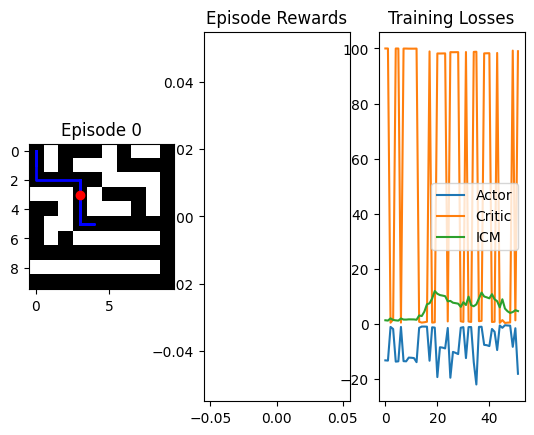

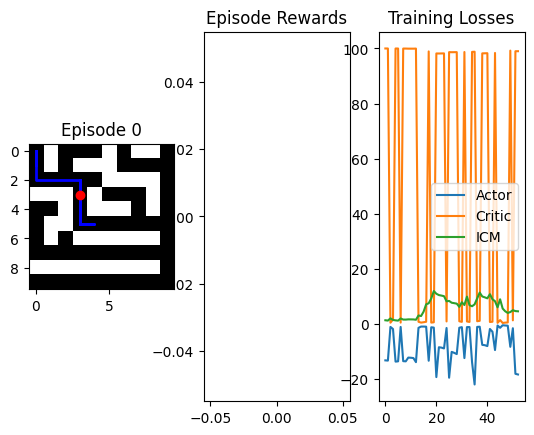

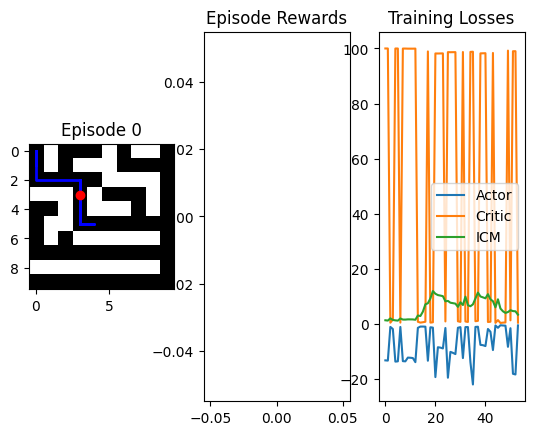

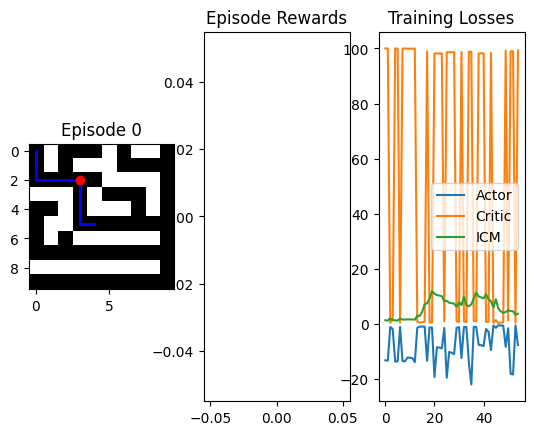

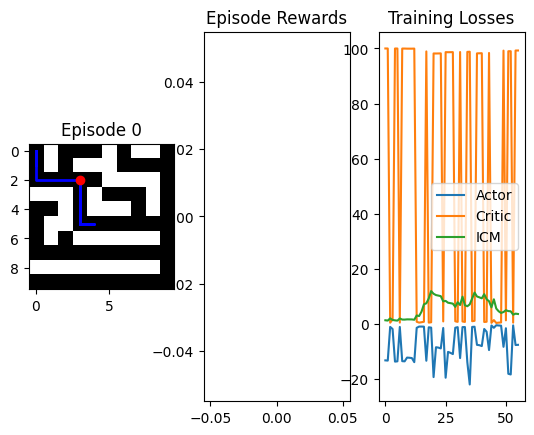

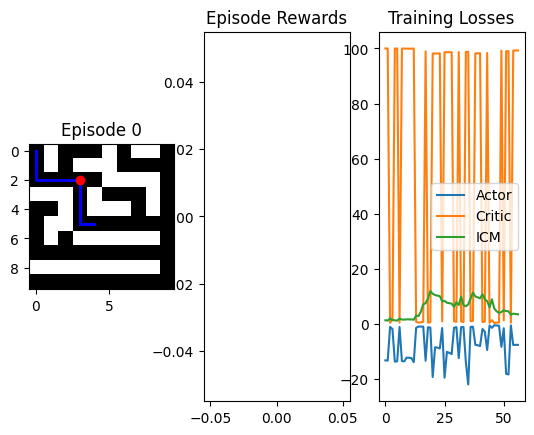

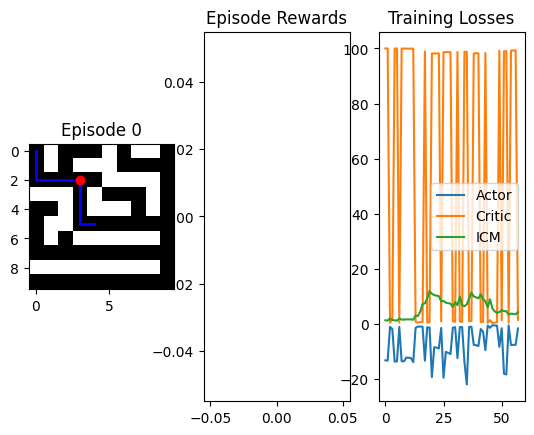

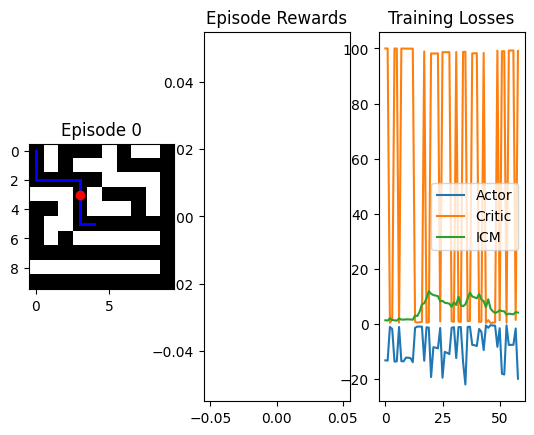

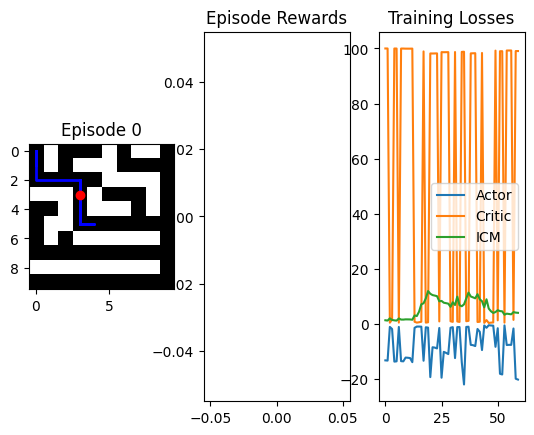

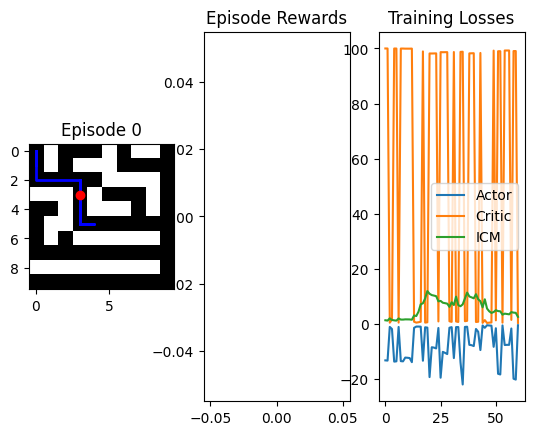

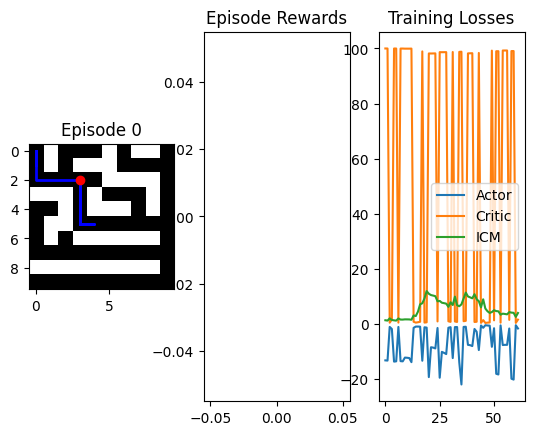

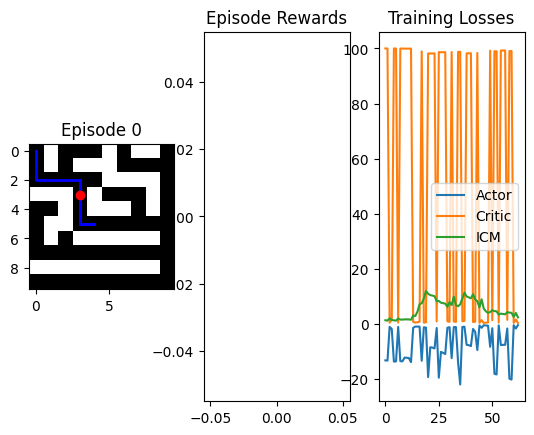

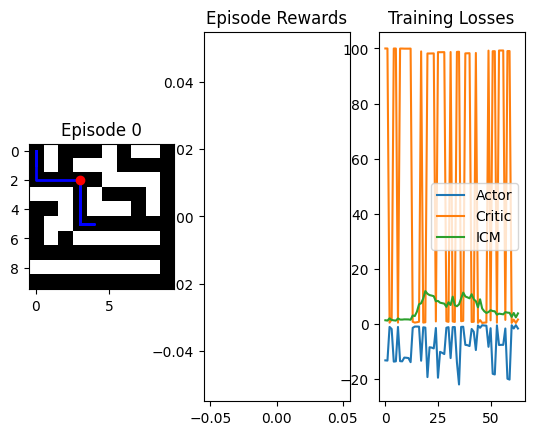

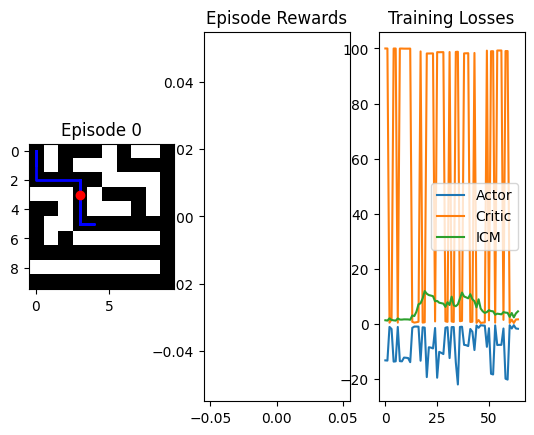

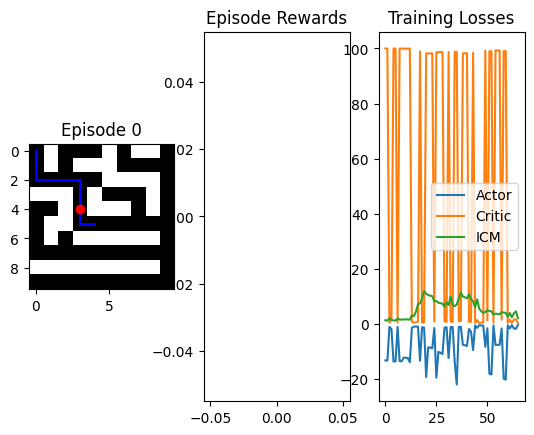

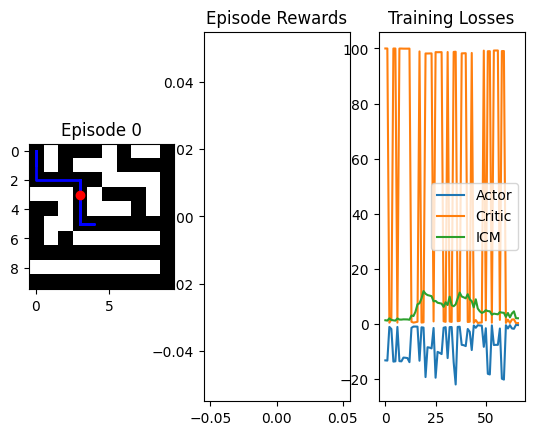

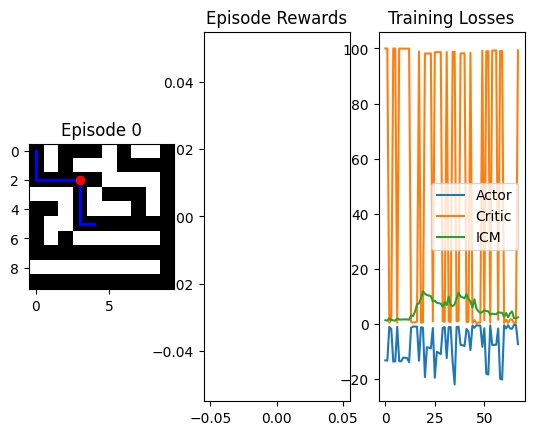

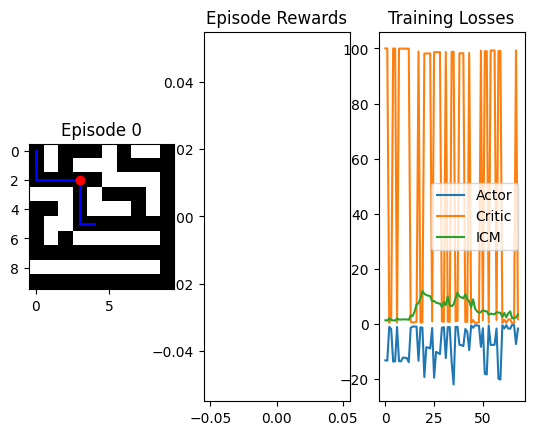

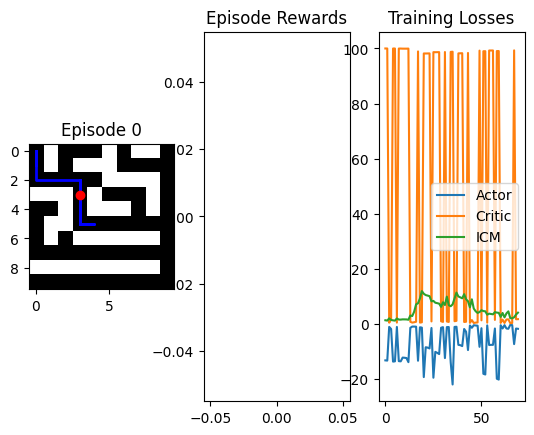

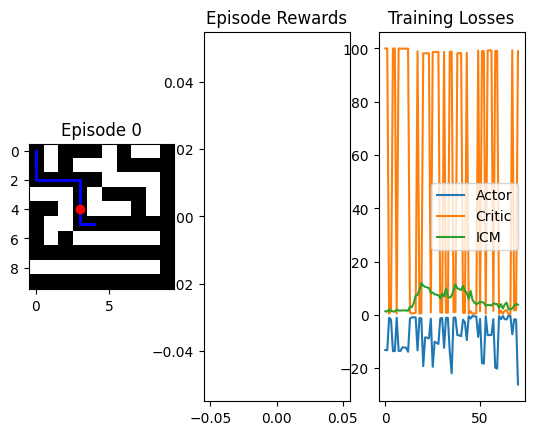

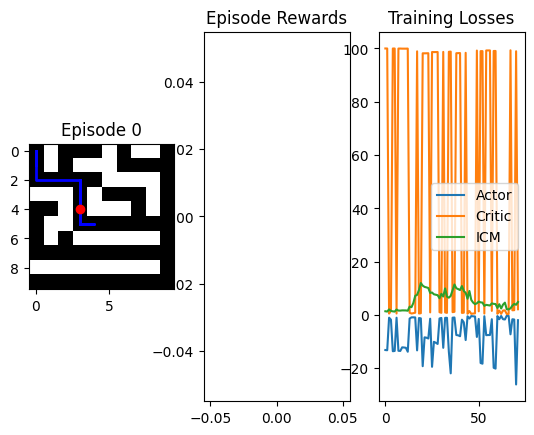

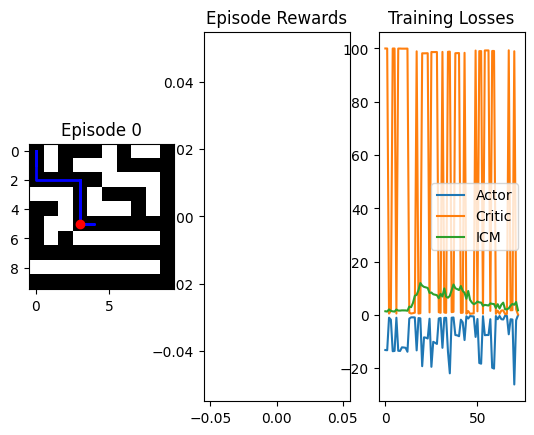

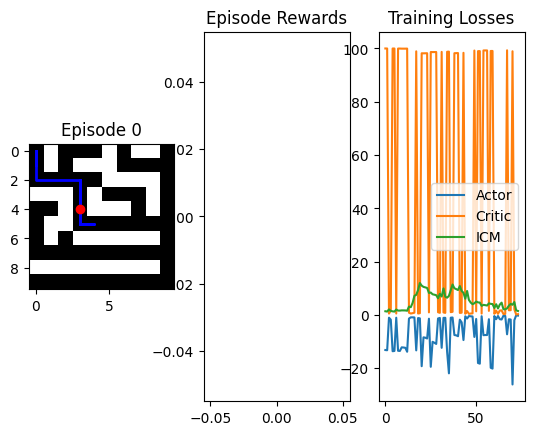

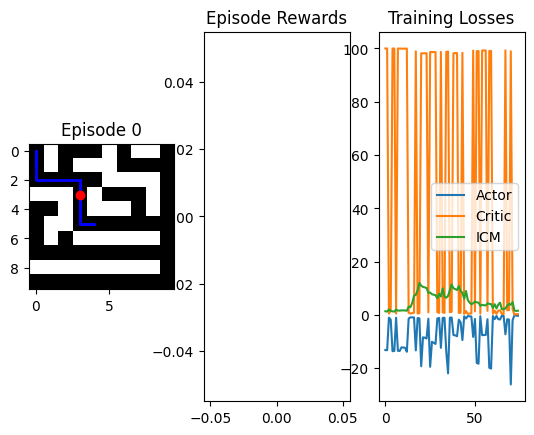

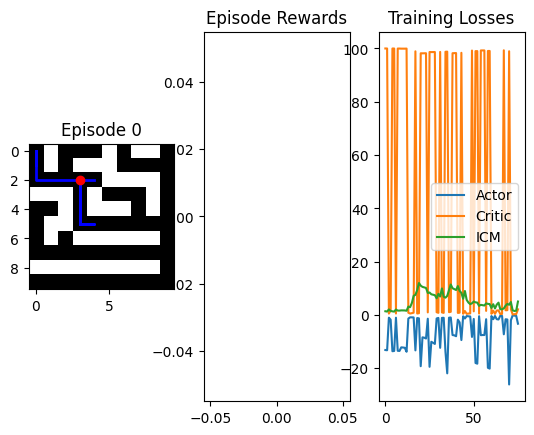

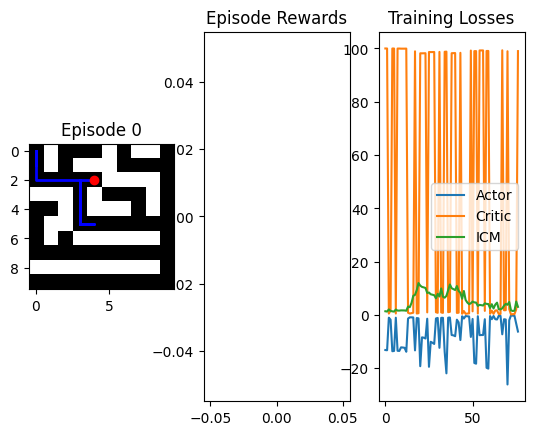

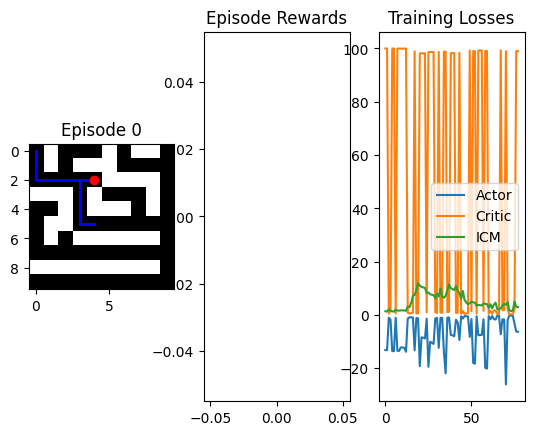

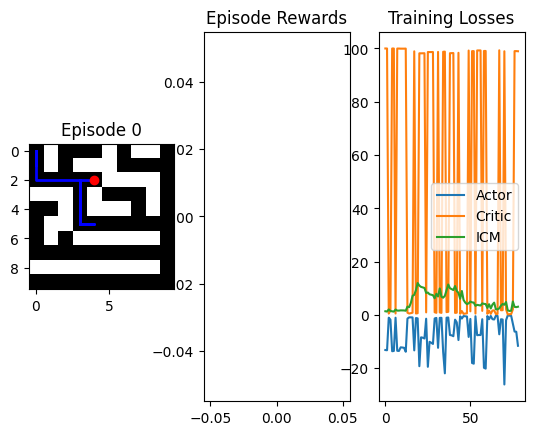

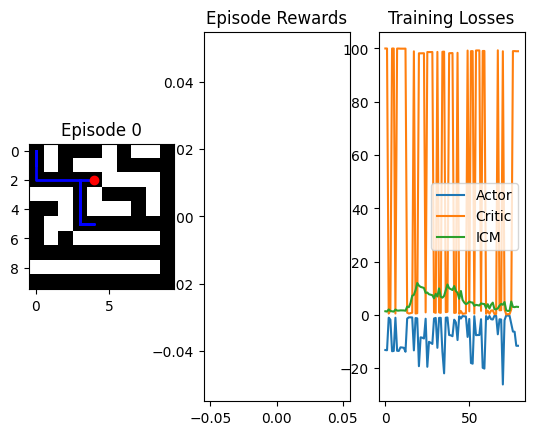

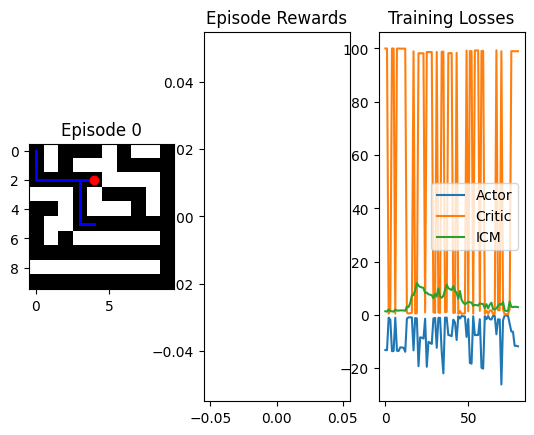

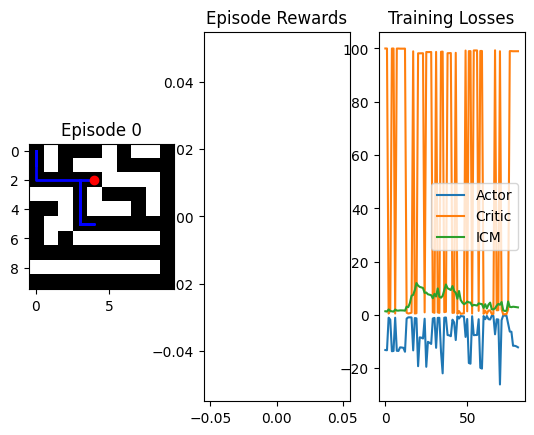

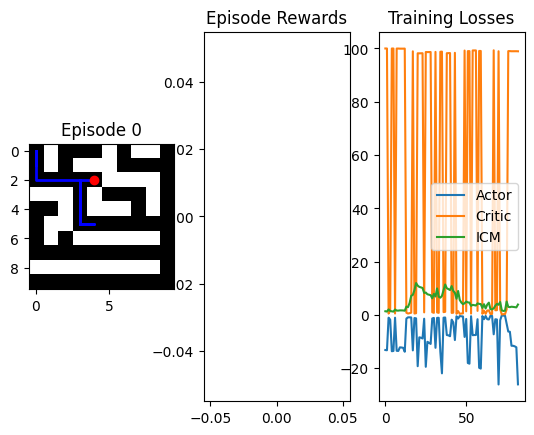

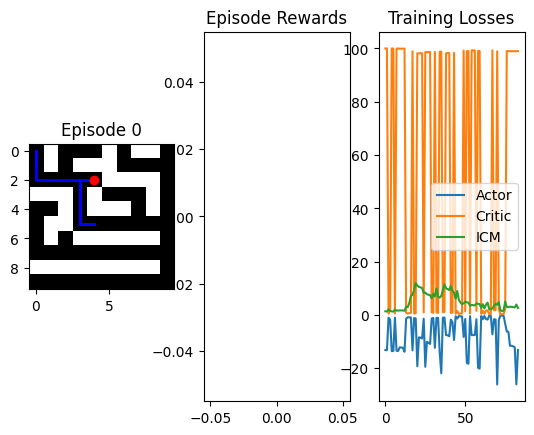

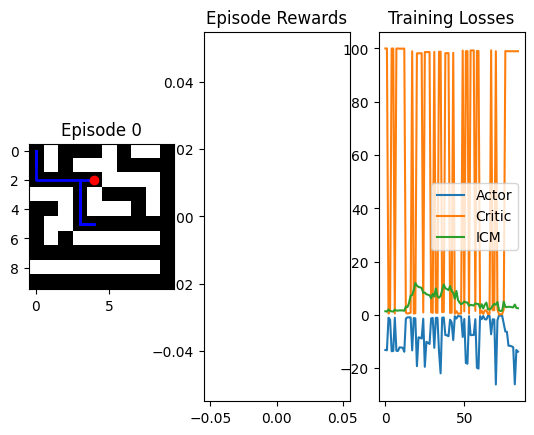

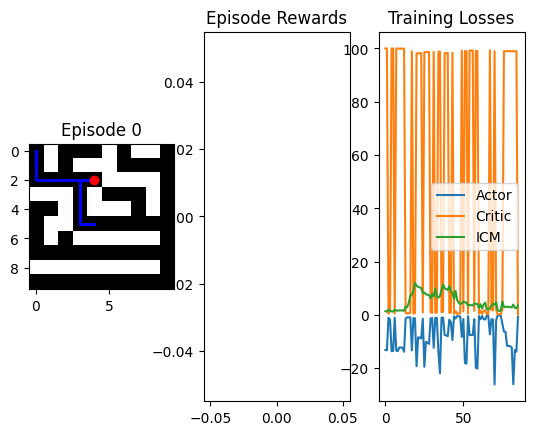

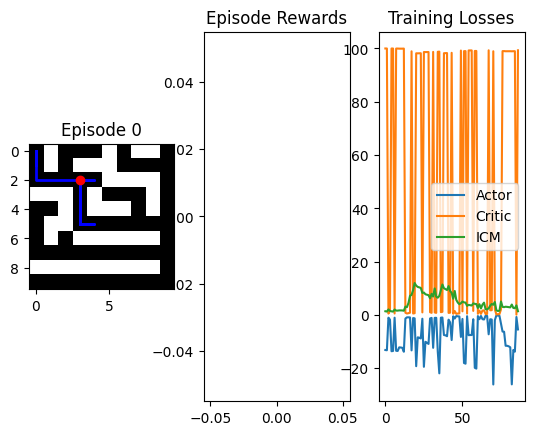

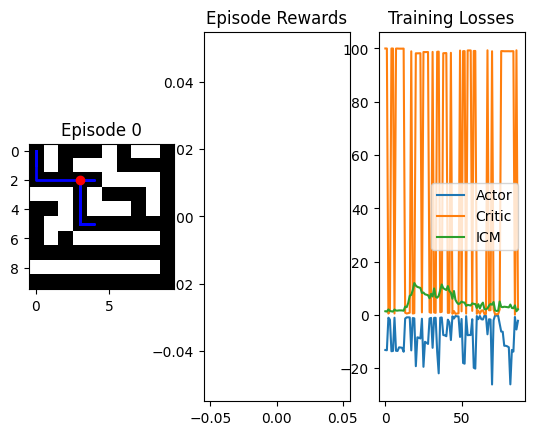

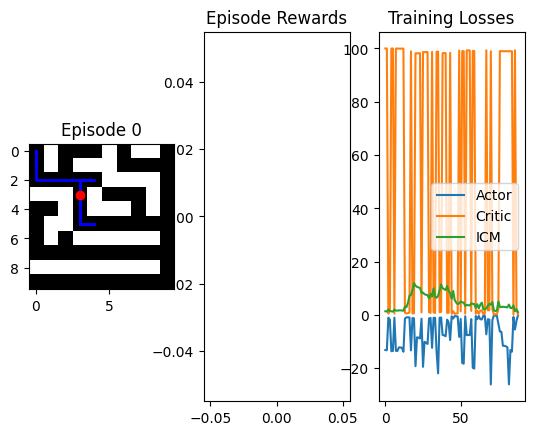

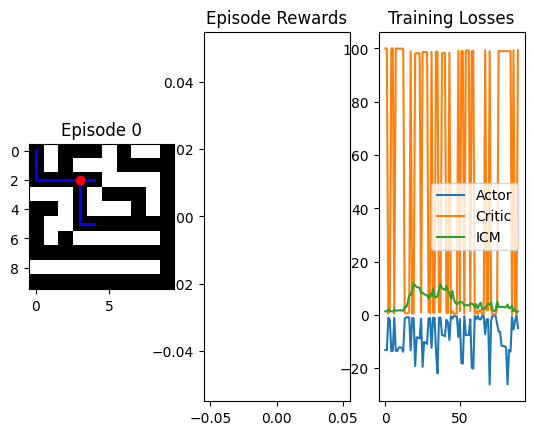

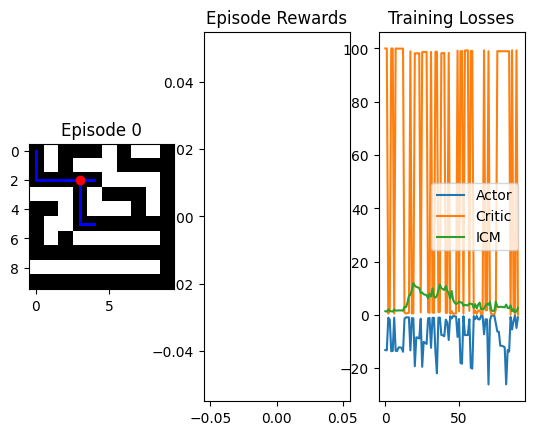

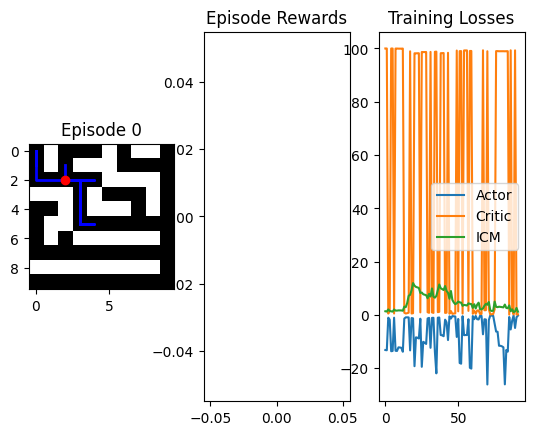

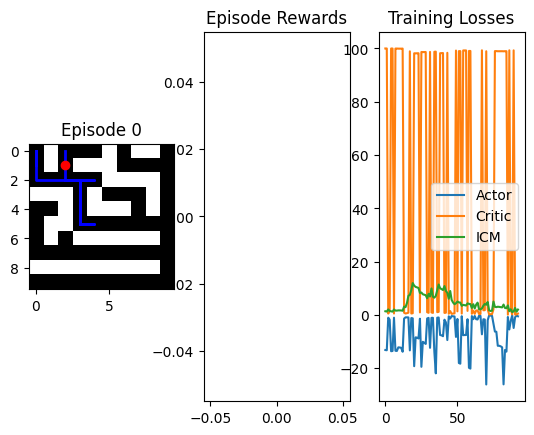

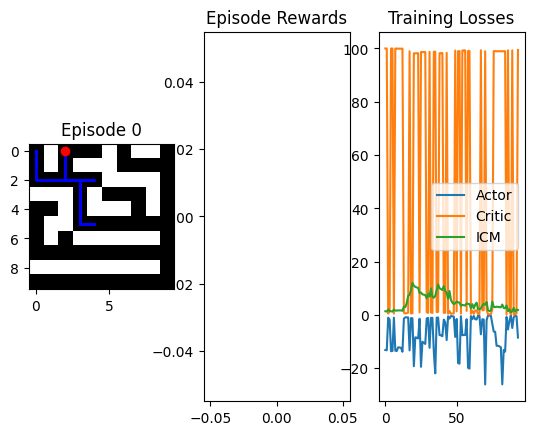

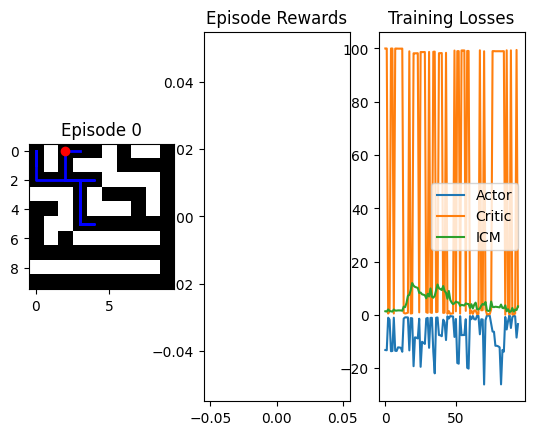

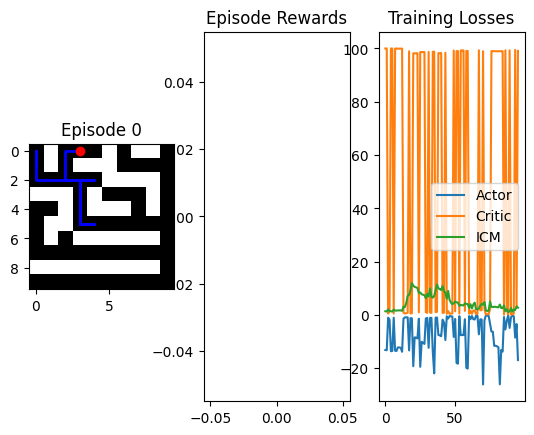

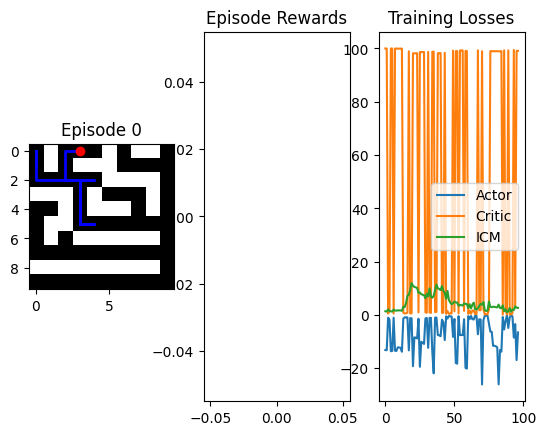

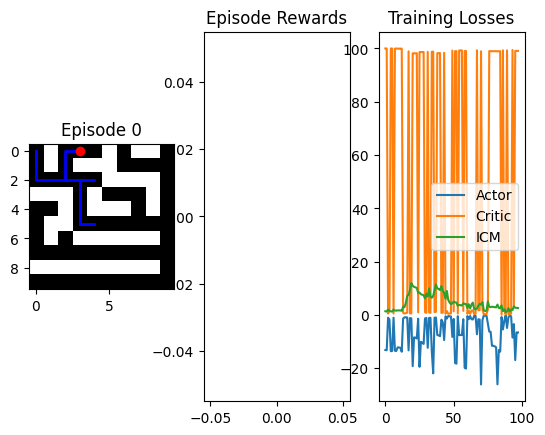

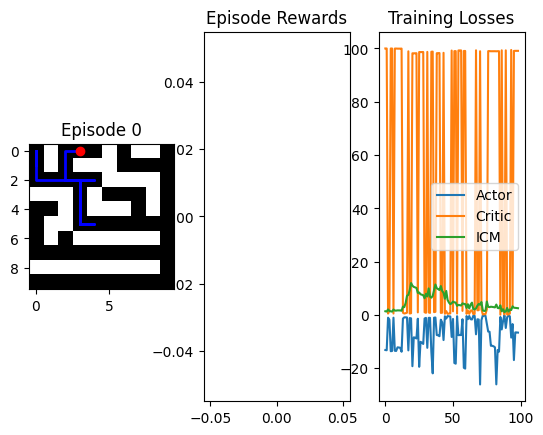

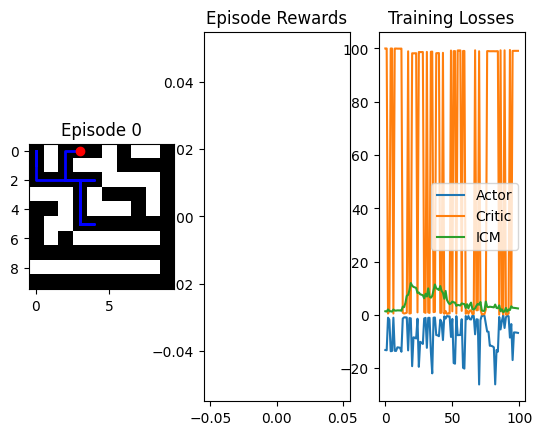

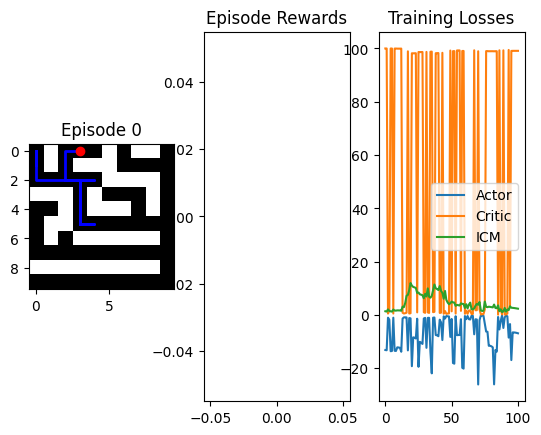

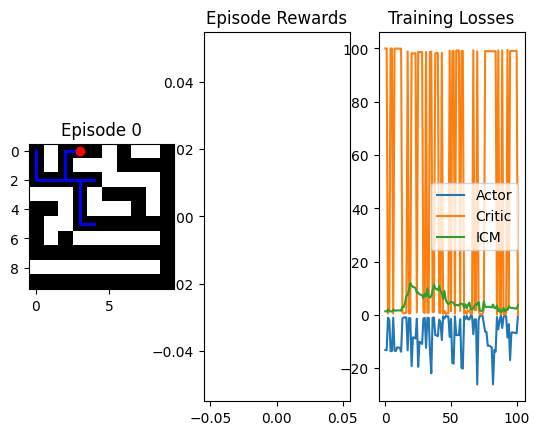

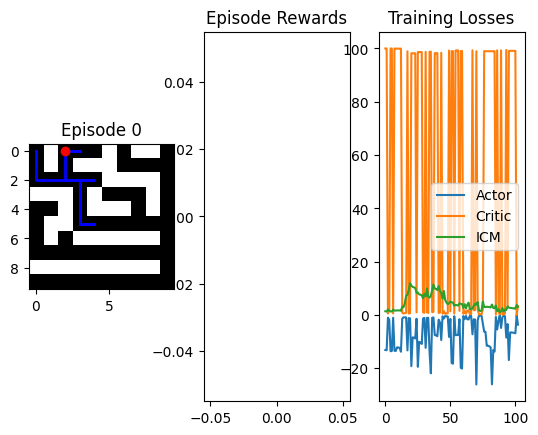

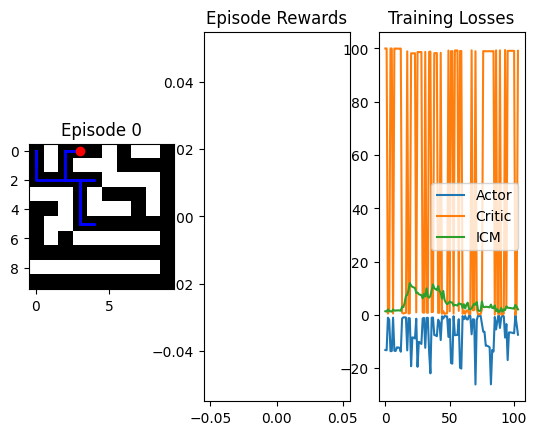

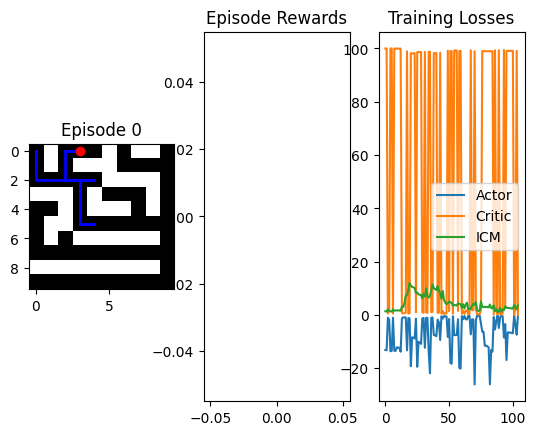

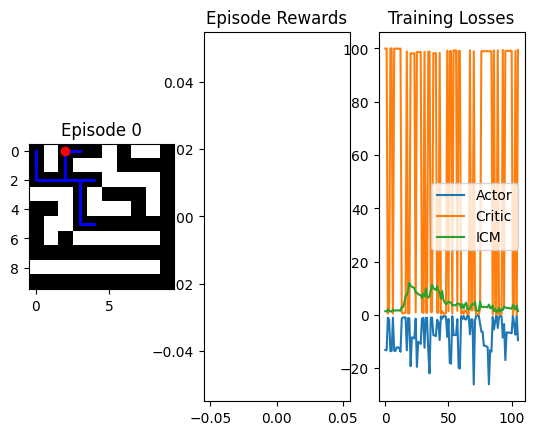

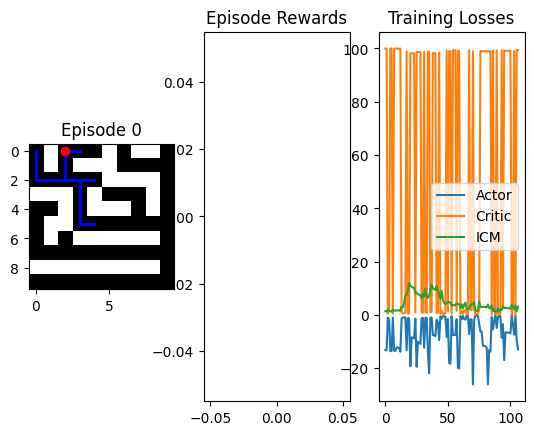

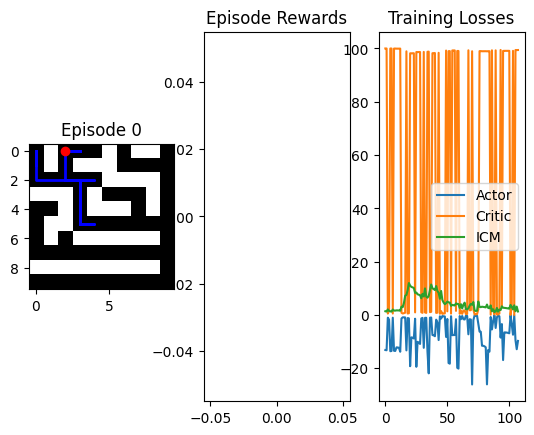

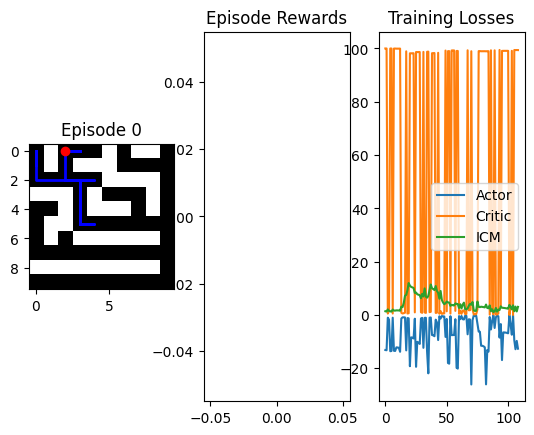

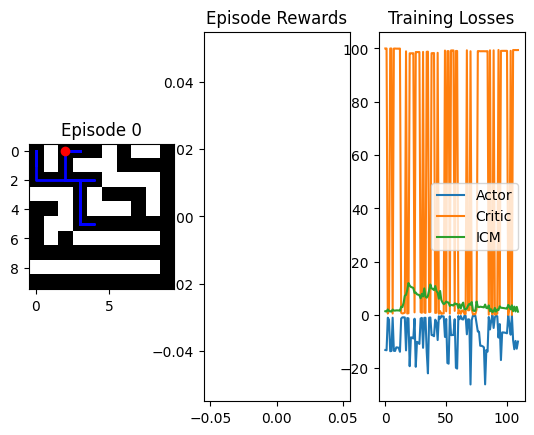

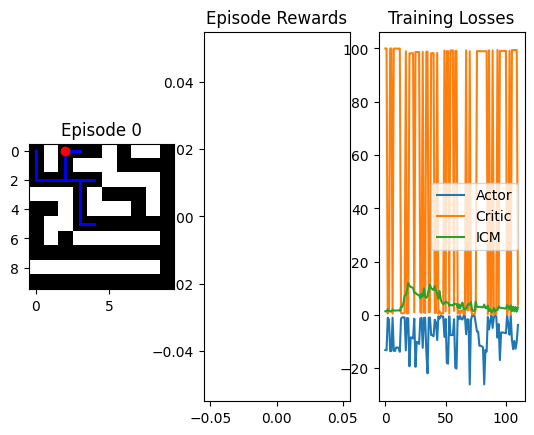

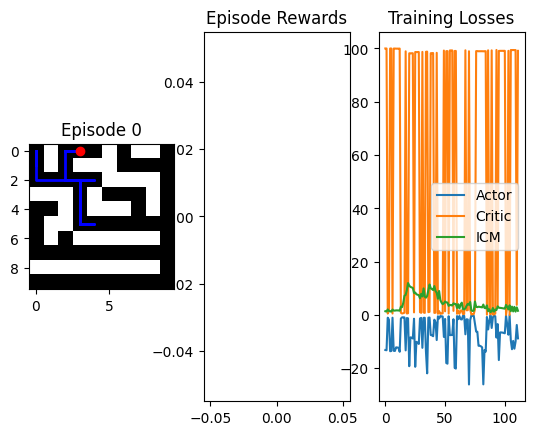

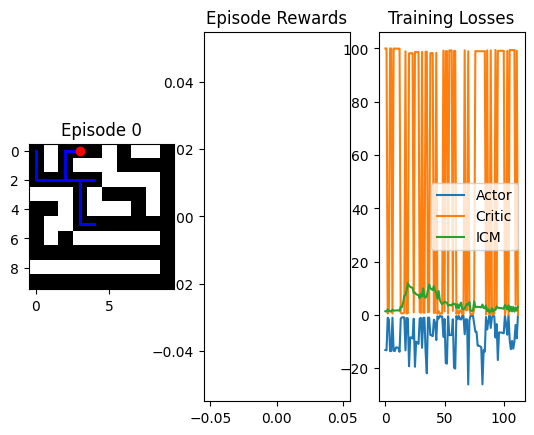

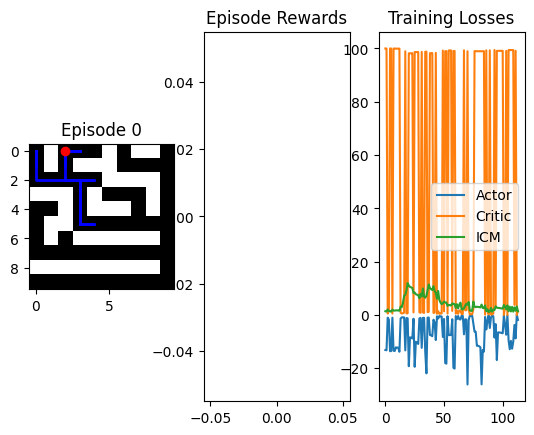

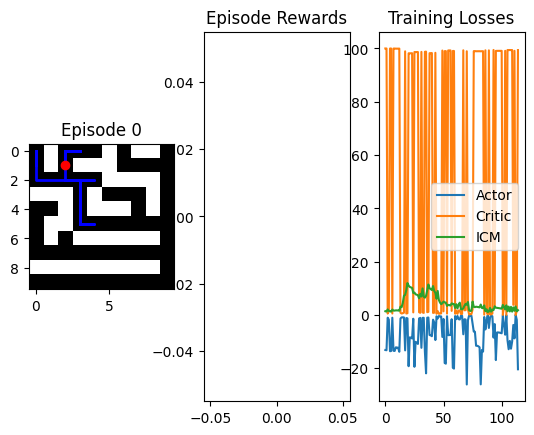

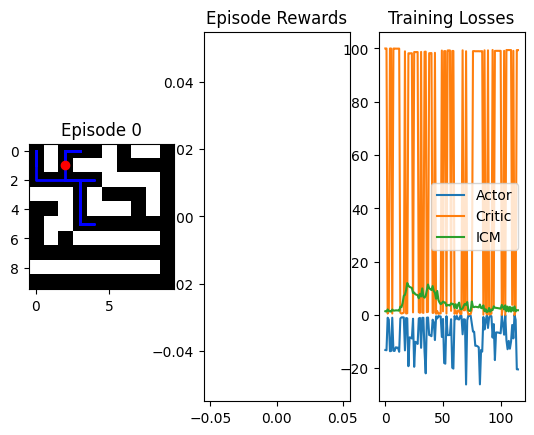

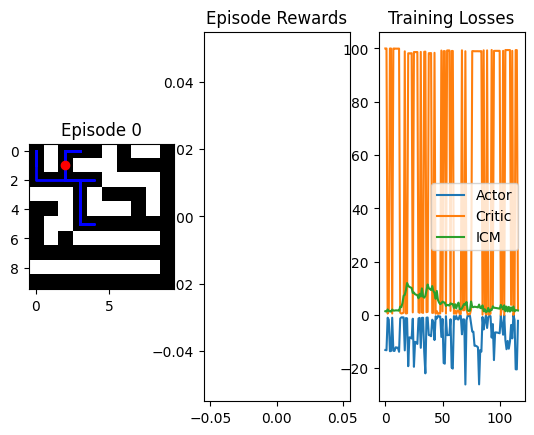

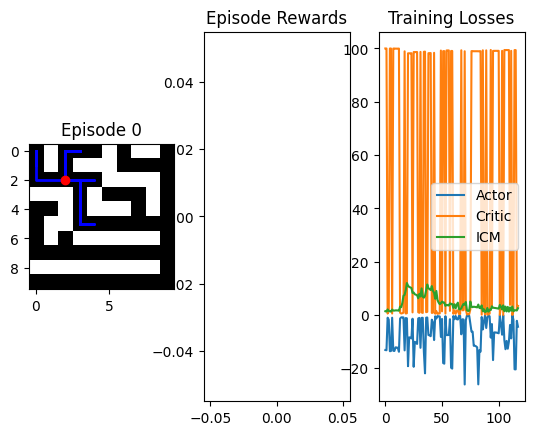

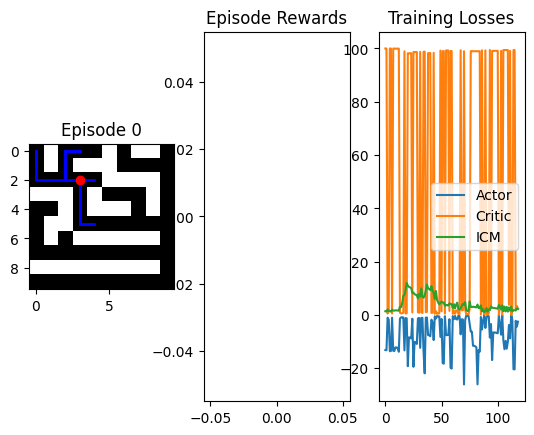

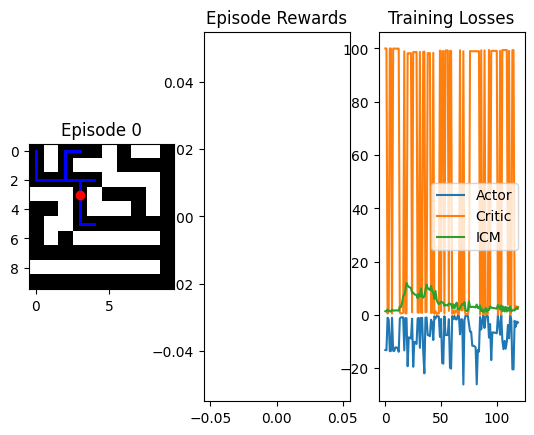

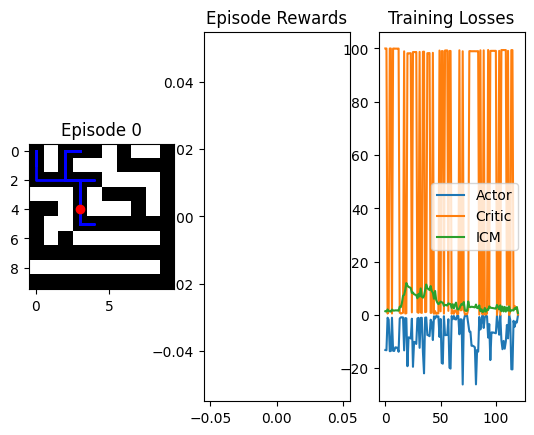

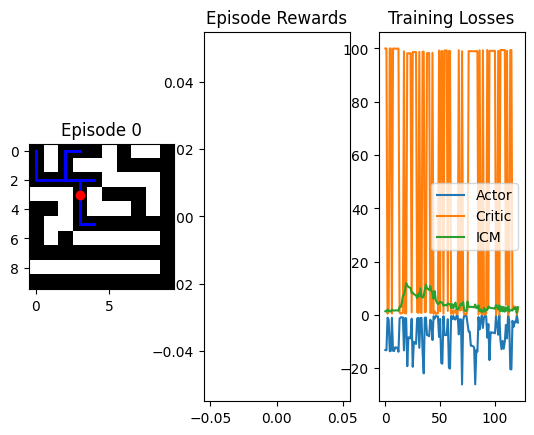

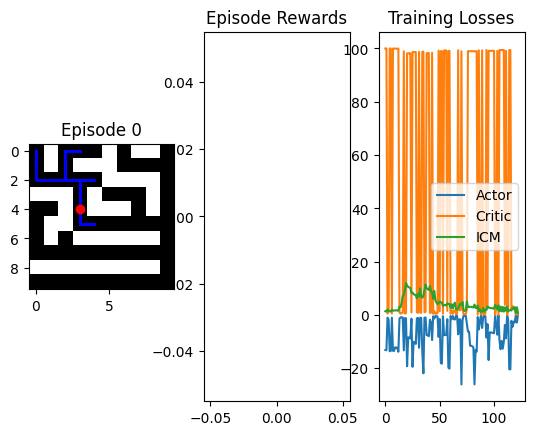

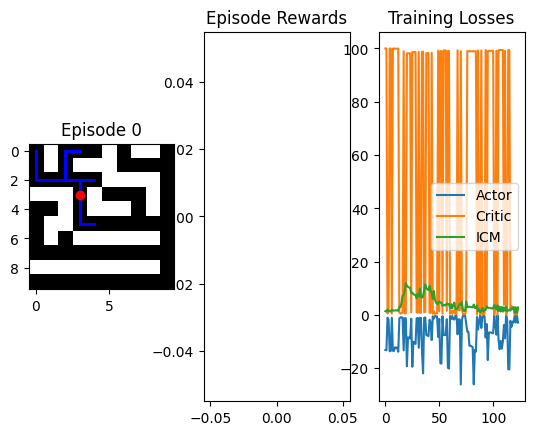

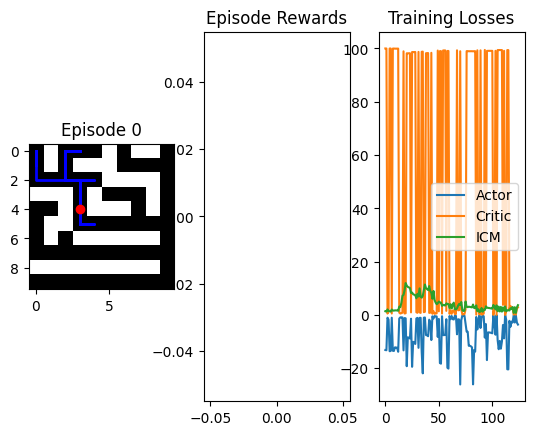

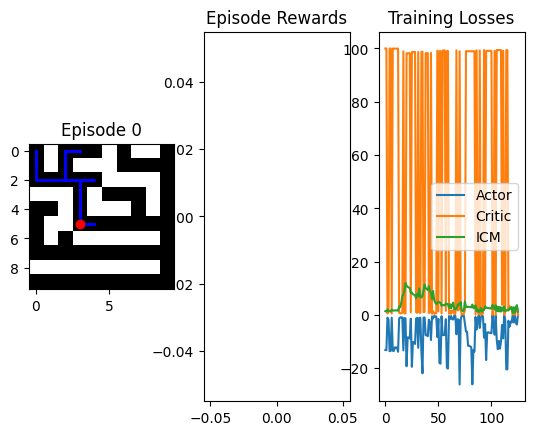

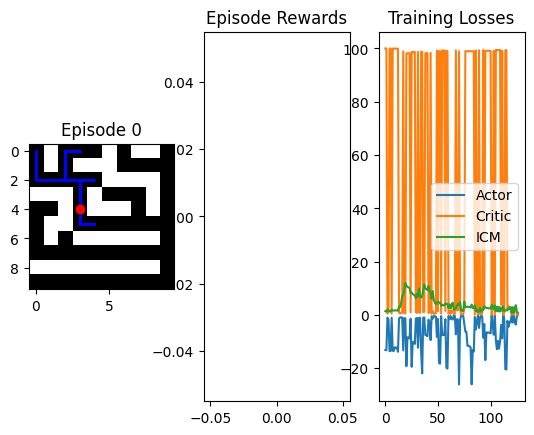

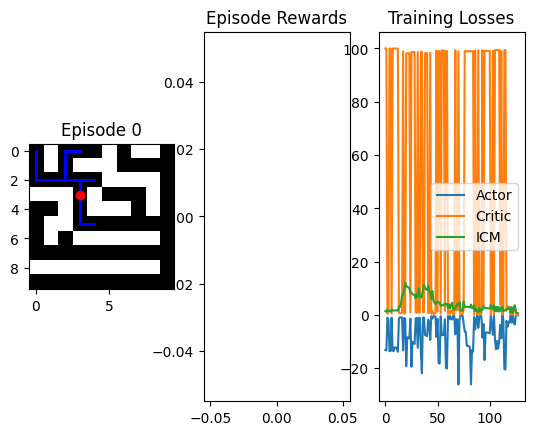

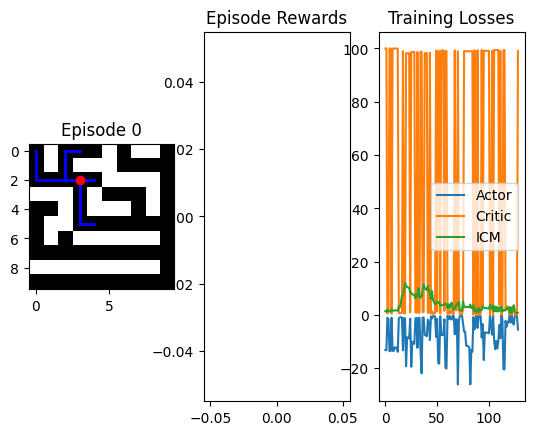

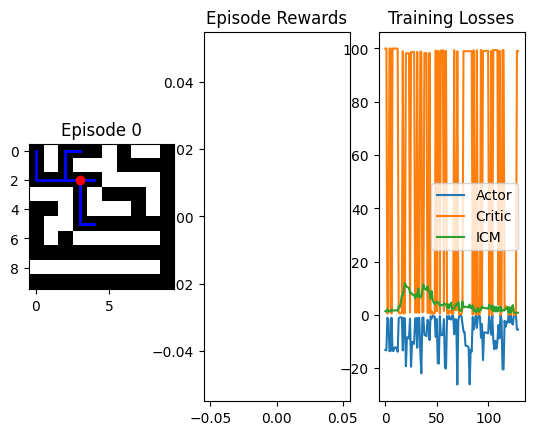

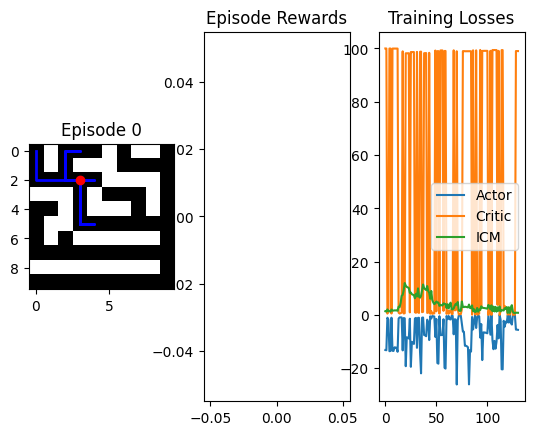

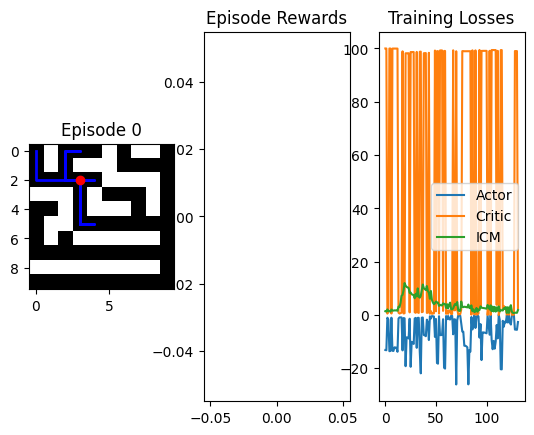

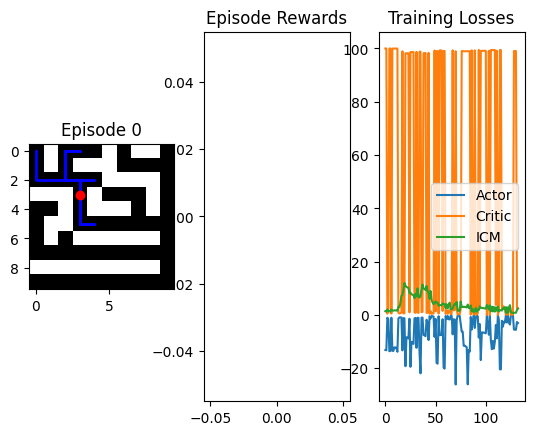

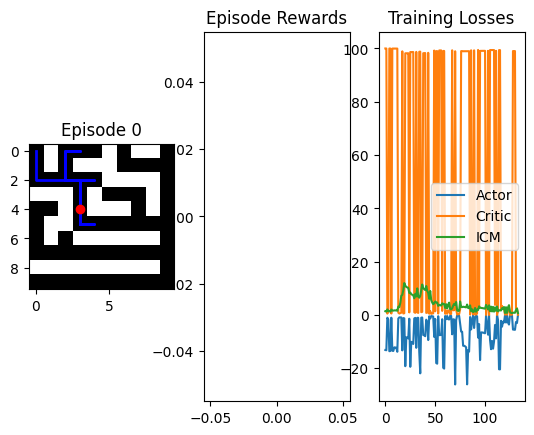

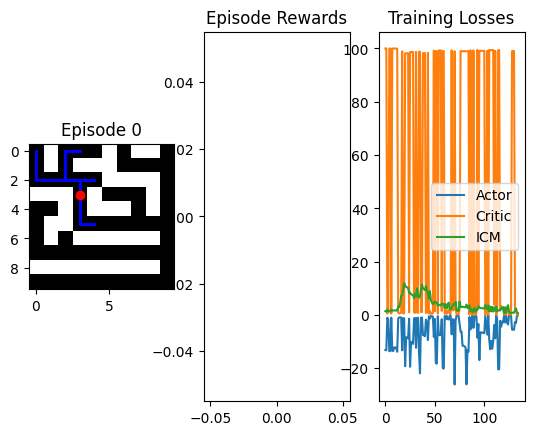

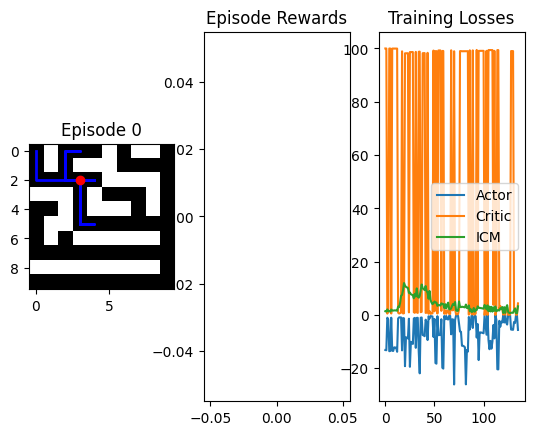

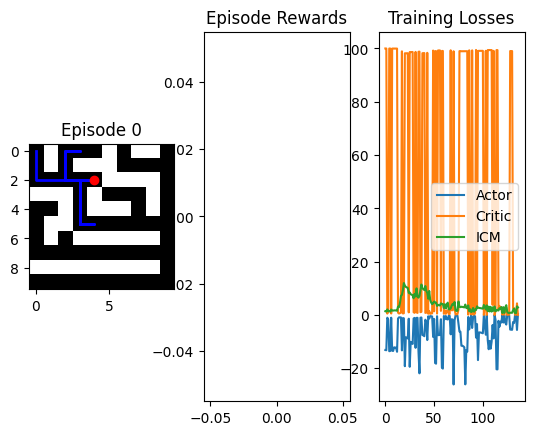

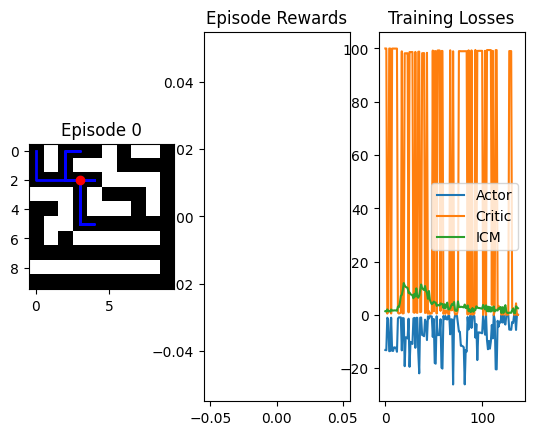

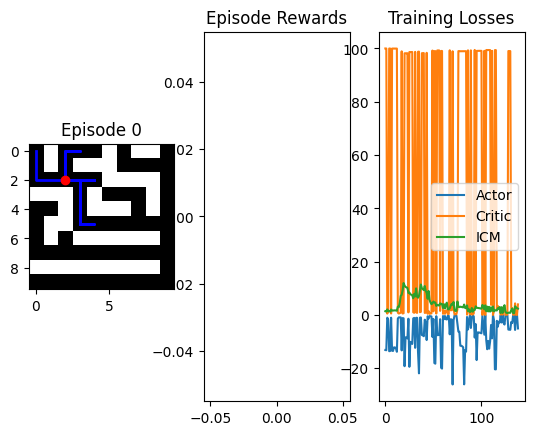

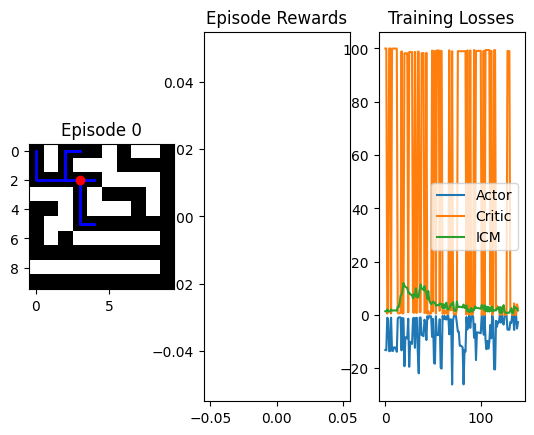

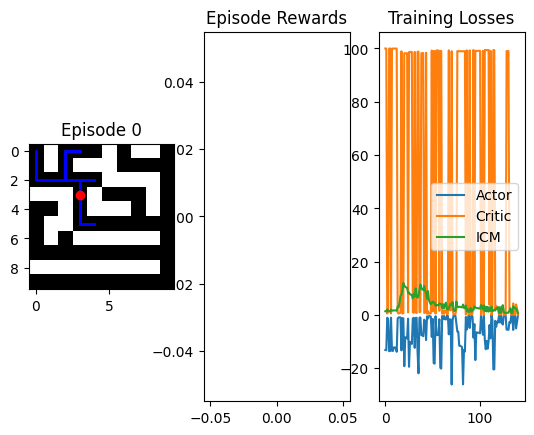

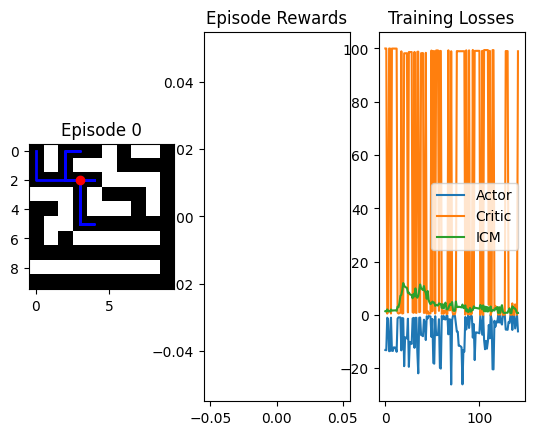

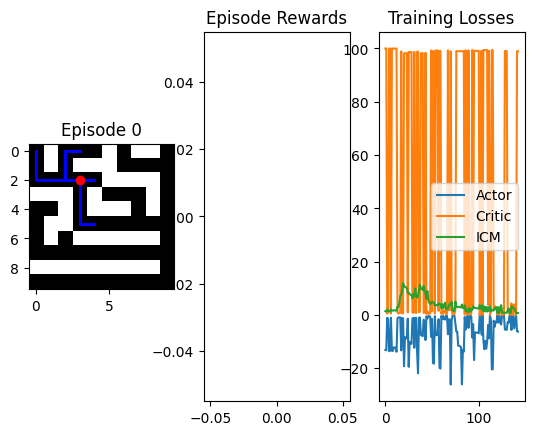

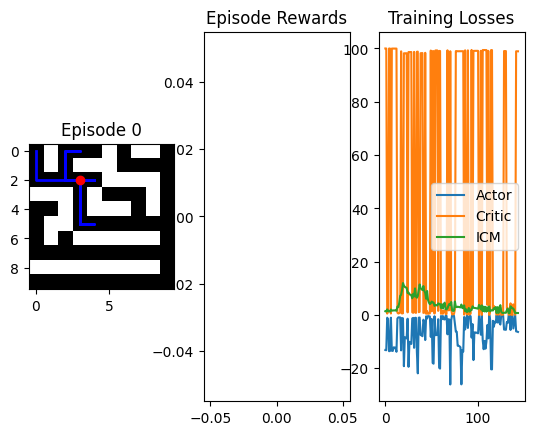

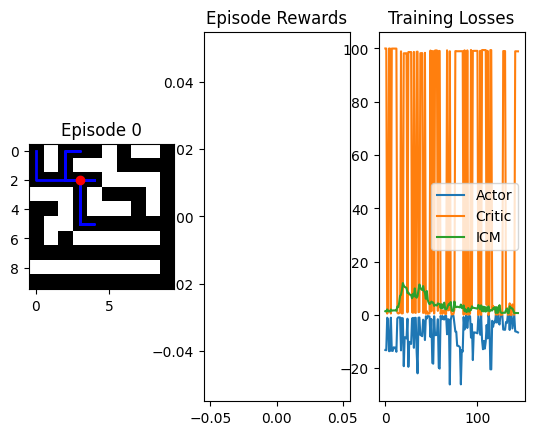

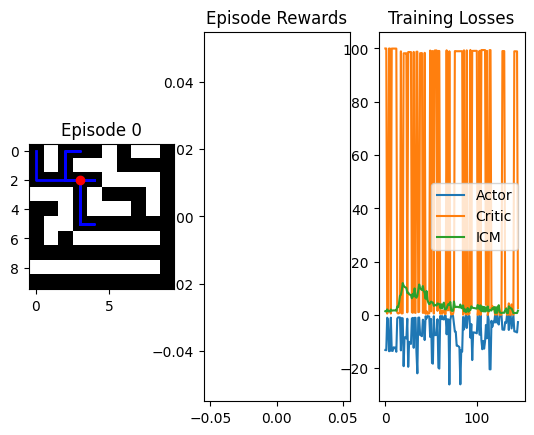

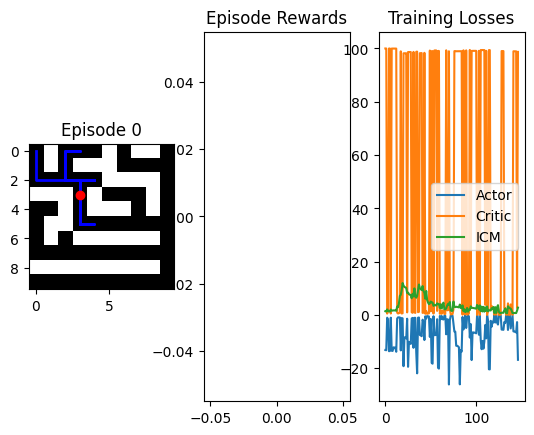

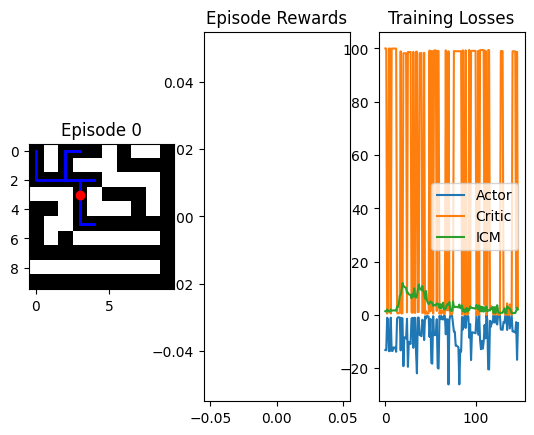

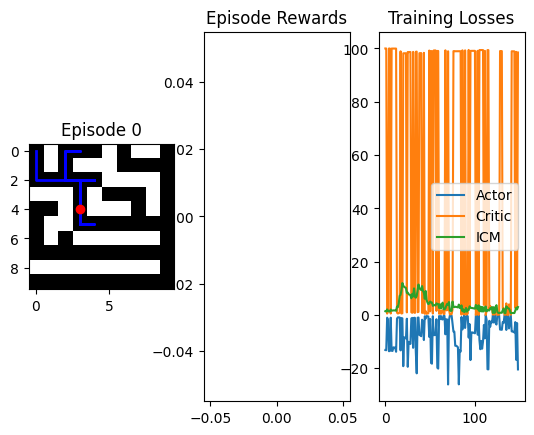

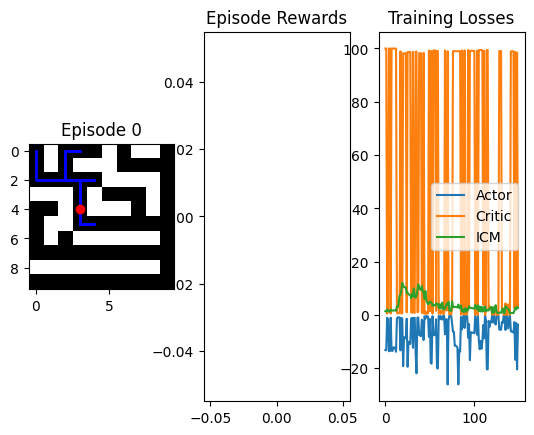

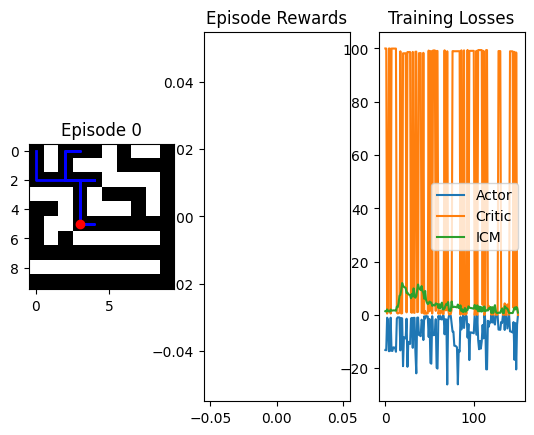

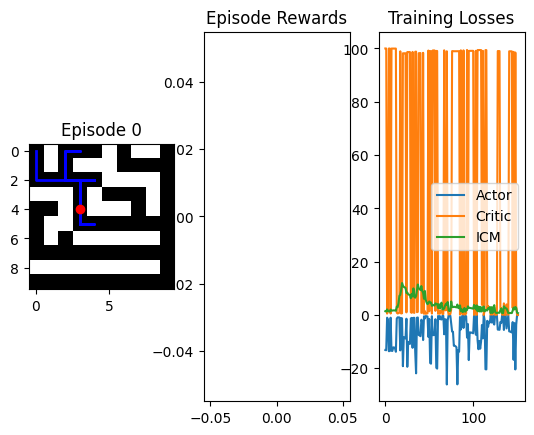

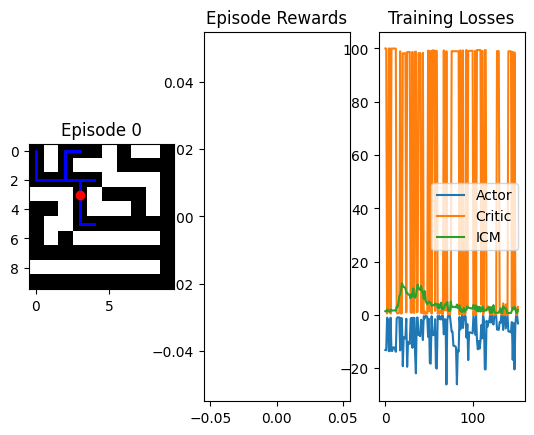

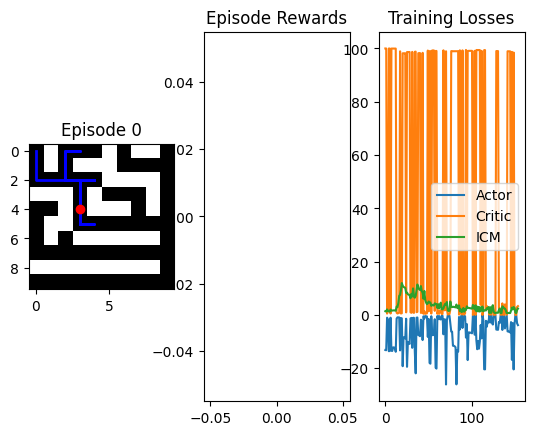

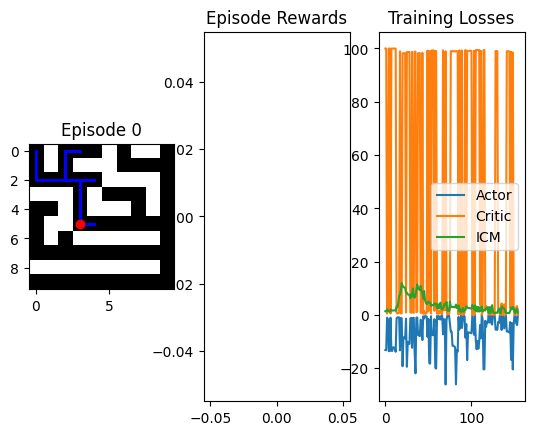

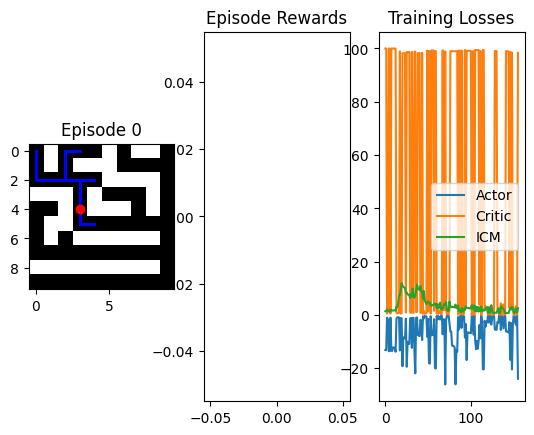

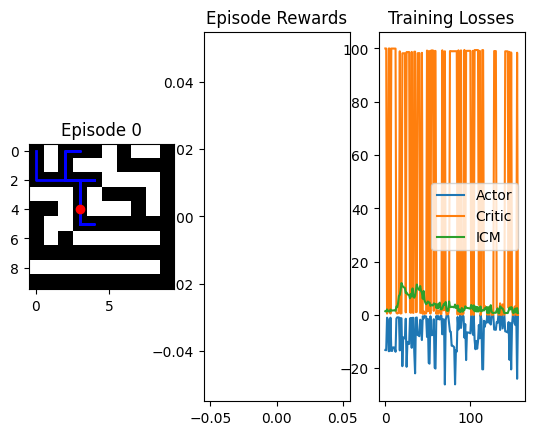

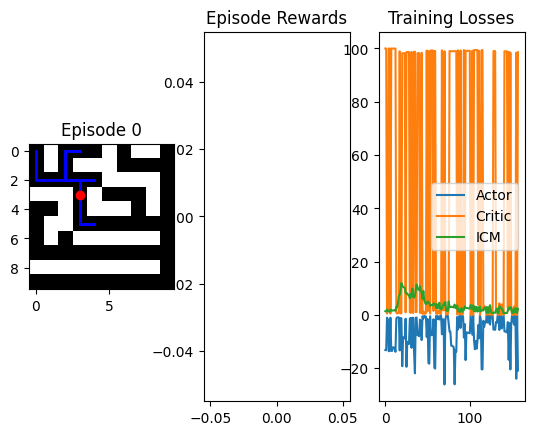

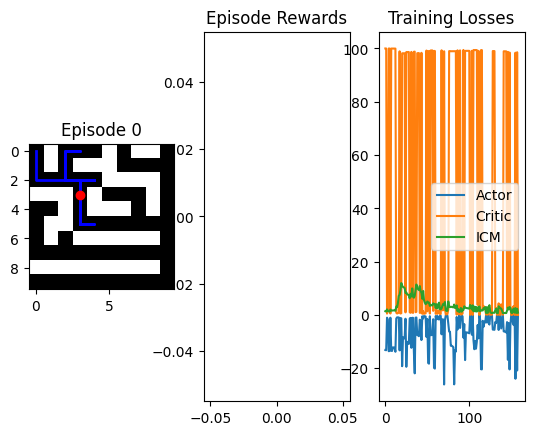

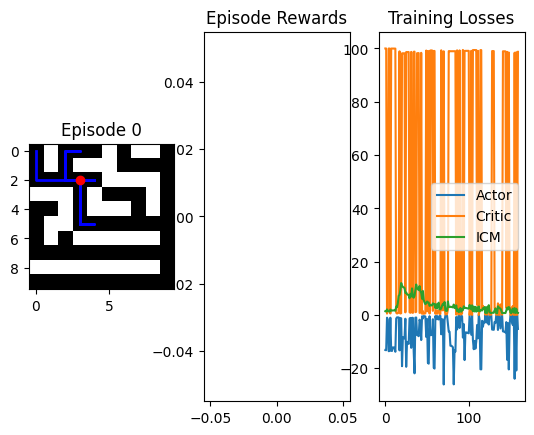

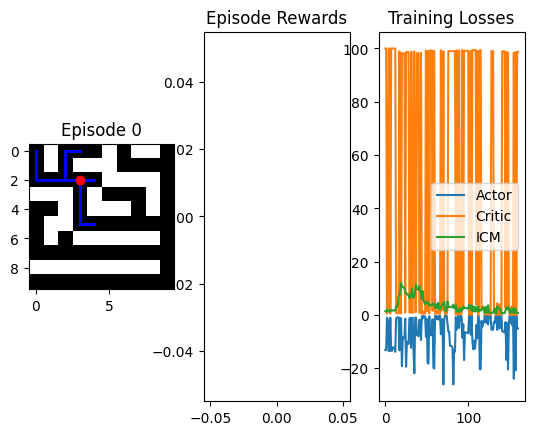

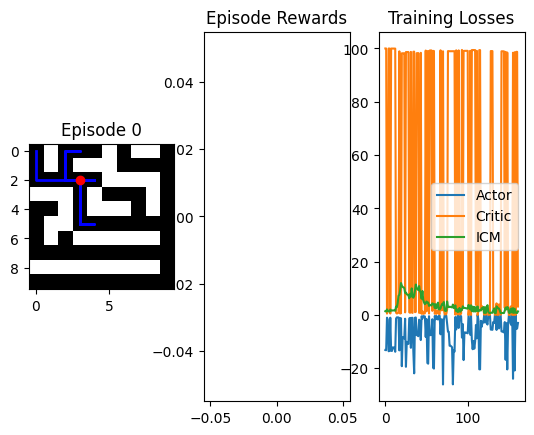

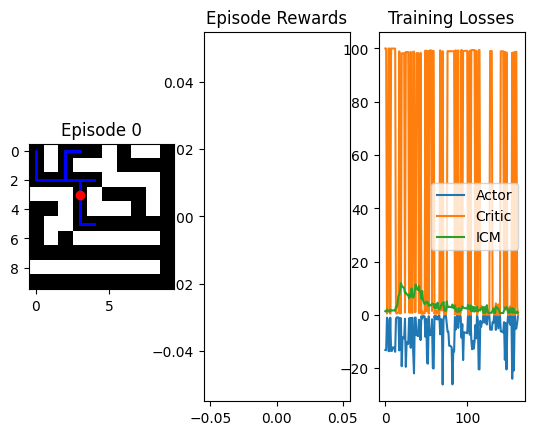

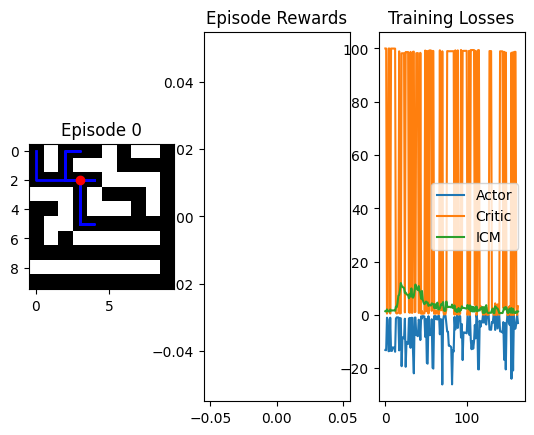

In [ ]:
# Train the agent
rewards, steps, losses = train_enhanced_agent(enhanced_agent, maze, num_episodes=200)

In [ ]:
# Test the trained agent
test_enhanced_agent(enhanced_agent, maze)